## Import packages and libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report,f1_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import RocCurveDisplay
from skopt import BayesSearchCV
import warnings
warnings.filterwarnings('ignore')

## Read the data

In [2]:
red_wine=pd.read_csv('https://raw.githubusercontent.com/FlipRoboTechnologies/ML-Datasets/main/Red%20Wine/winequality-red.csv')
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Initial exploration

In [3]:
red_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
red_wine.quality.value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

In [5]:
red_wine.quality.unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

In [6]:
red_wine['target']=np.where(red_wine.quality>6,1,0)
red_wine.target.value_counts(normalize=True)

target
0    0.86429
1    0.13571
Name: proportion, dtype: float64

In [7]:
for col in red_wine.columns.values[:-2]:
    print(f'{col}: {red_wine[col].unique().size}')

fixed acidity: 96
volatile acidity: 143
citric acid: 80
residual sugar: 91
chlorides: 153
free sulfur dioxide: 60
total sulfur dioxide: 144
density: 436
pH: 89
sulphates: 96
alcohol: 65


In [8]:
red_wine.drop(columns=['quality'], inplace=True)
red_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  target                1599 non-null   int32  
dtypes: float64(11), int32(1)
memory usage: 143.8 KB


In [9]:
red_wine_eda=red_wine.copy()
red_wine_eda.target=red_wine_eda.target.map({0:'Bad',1:'Good'})
red_wine_eda

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,Bad
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,Bad
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,Bad
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,Bad
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,Bad
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,Bad
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,Bad
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,Bad
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,Bad


## EDA

### Univariate analysis

In [10]:
red_wine_eda.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


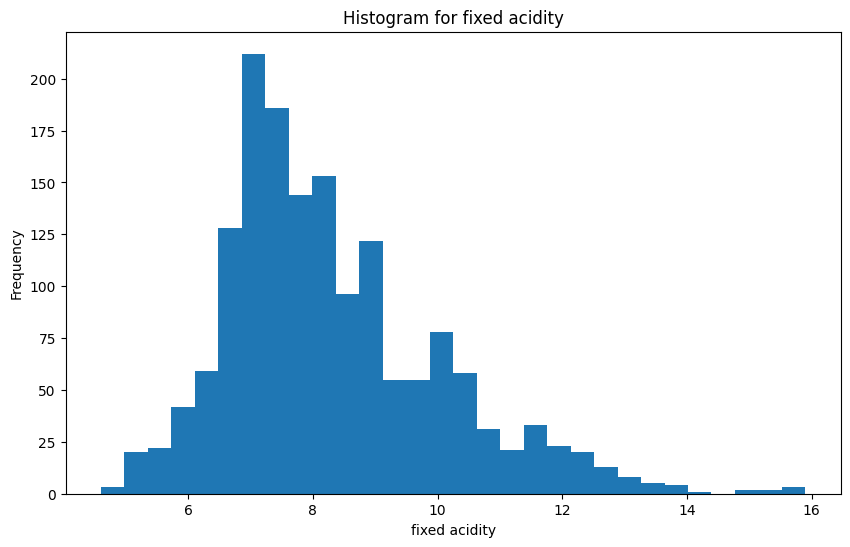

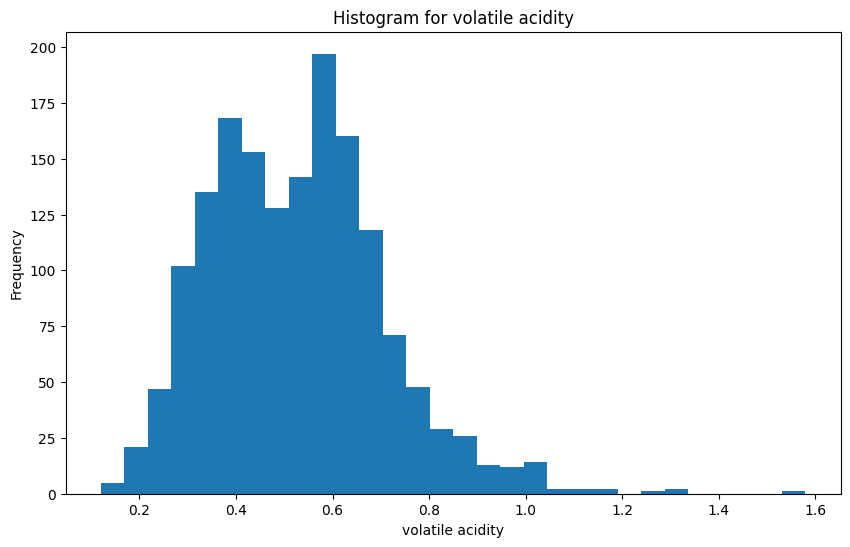

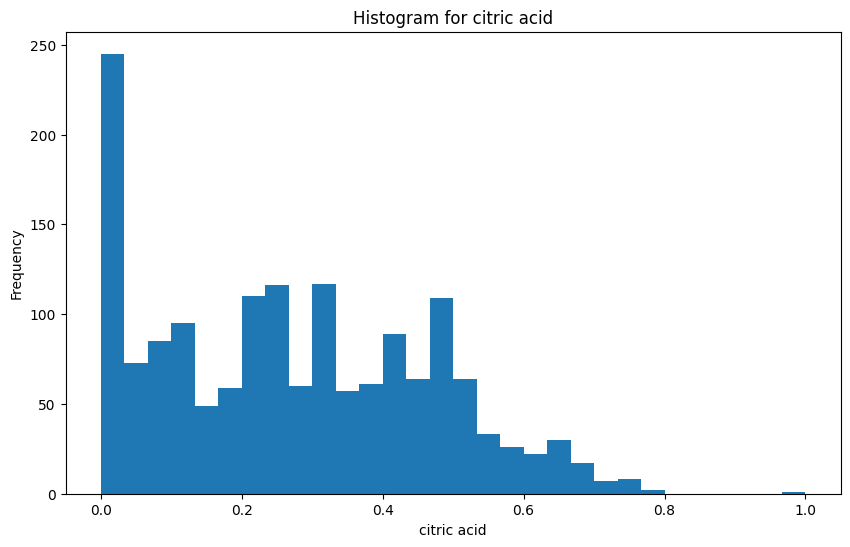

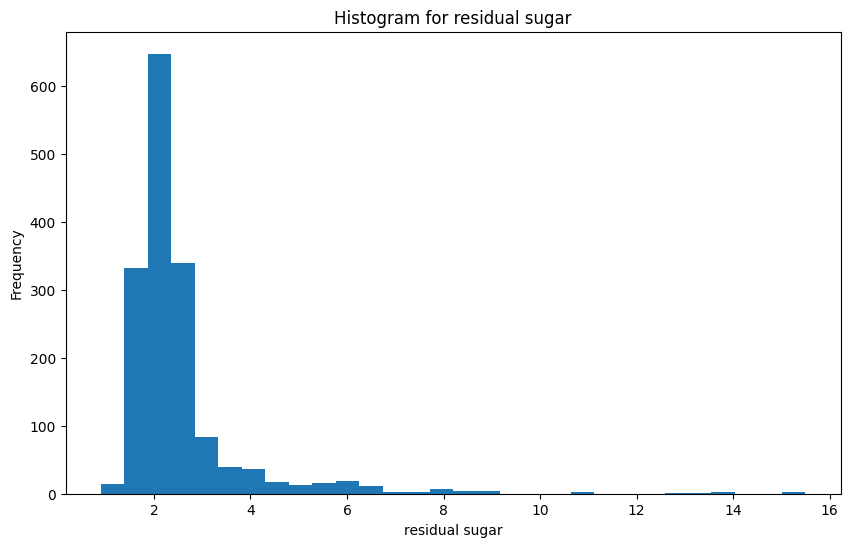

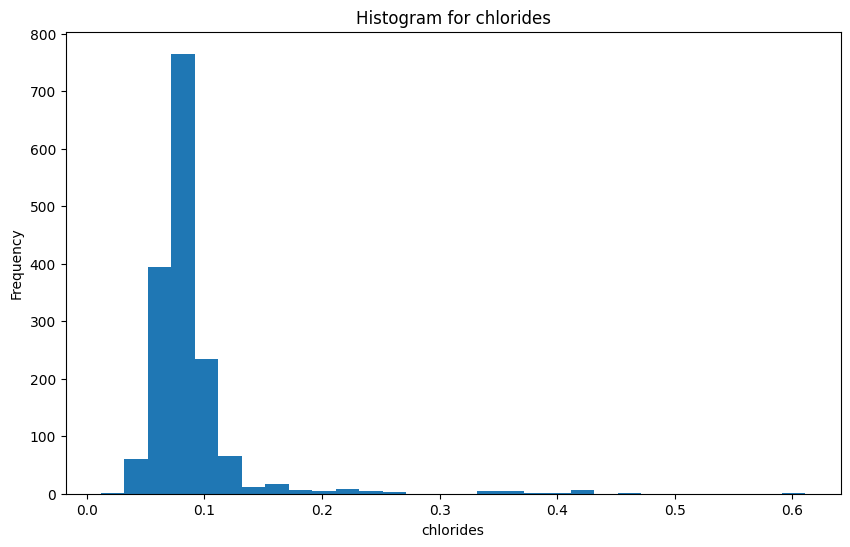

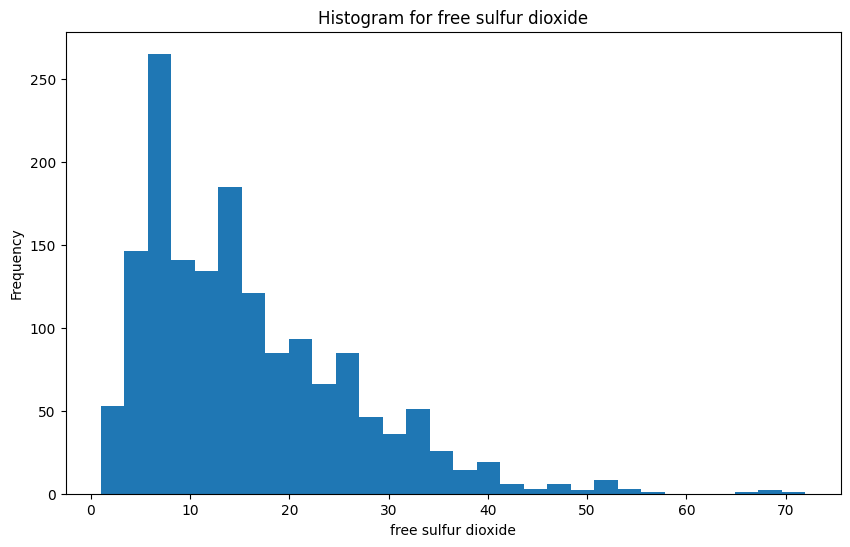

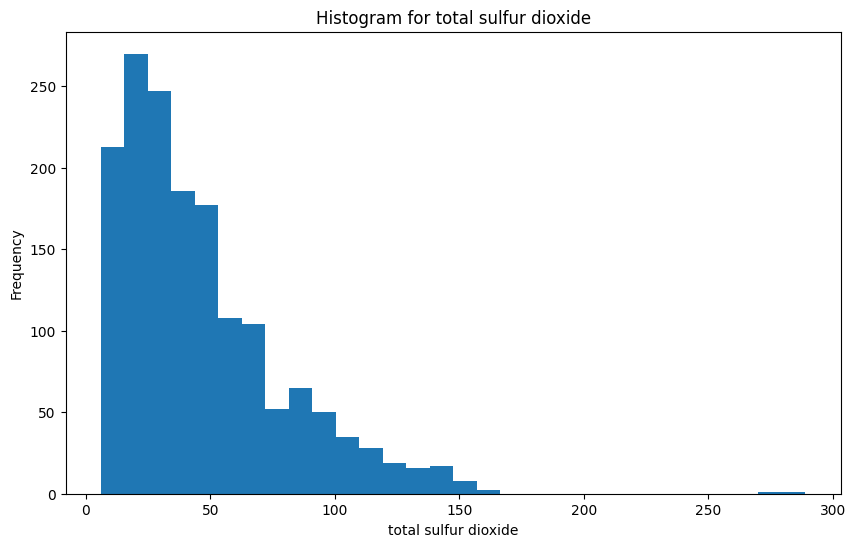

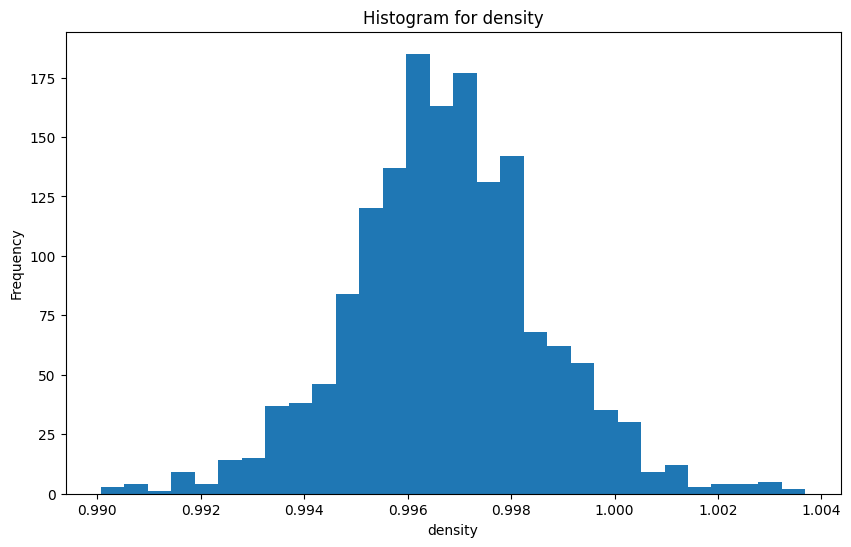

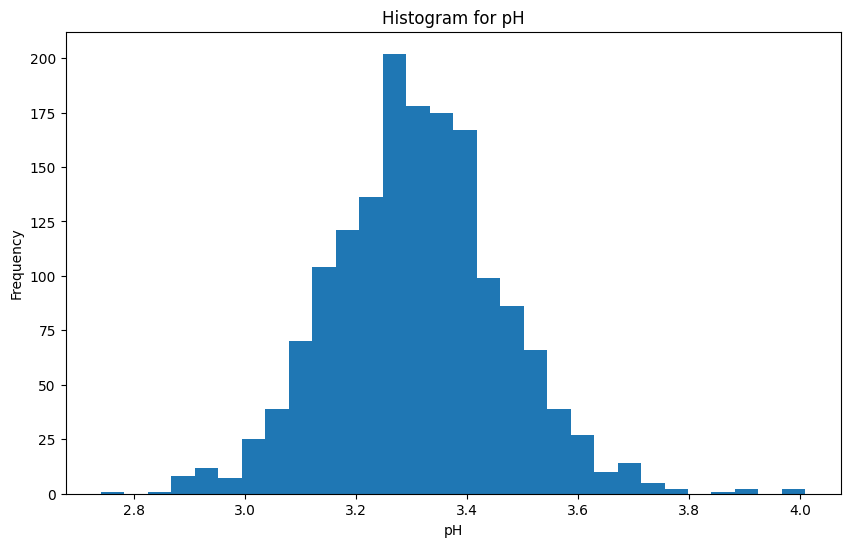

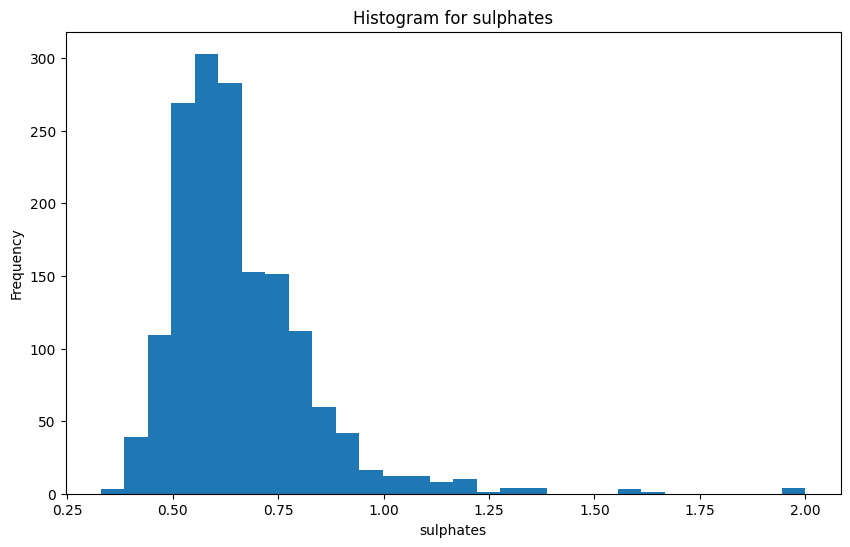

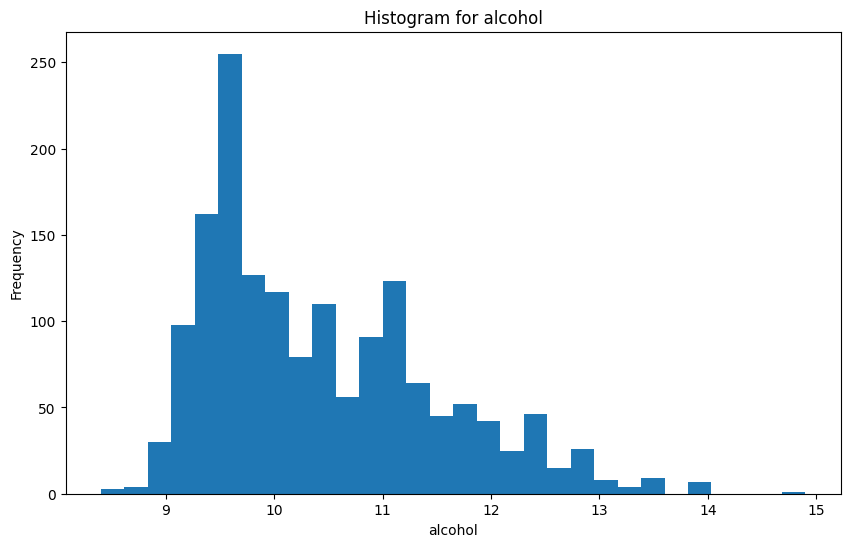

In [11]:
def show_histogram(df):
    for col in df.columns.values:
        fig=plt.figure(figsize=(10,6))
        df[col].plot.hist(bins=30)
        plt.title(f'Histogram for {col}')
        plt.xlabel(col)
        plt.show()
show_histogram(red_wine_eda.drop(columns='target'))

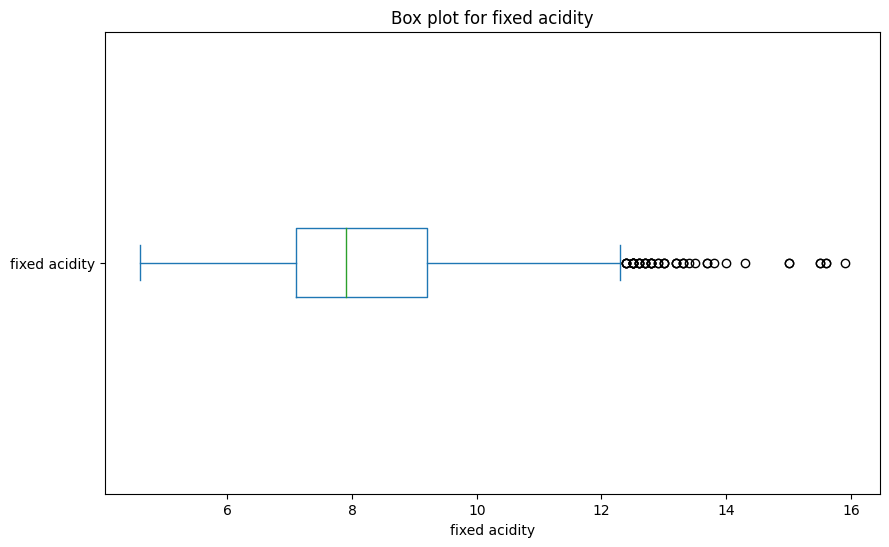

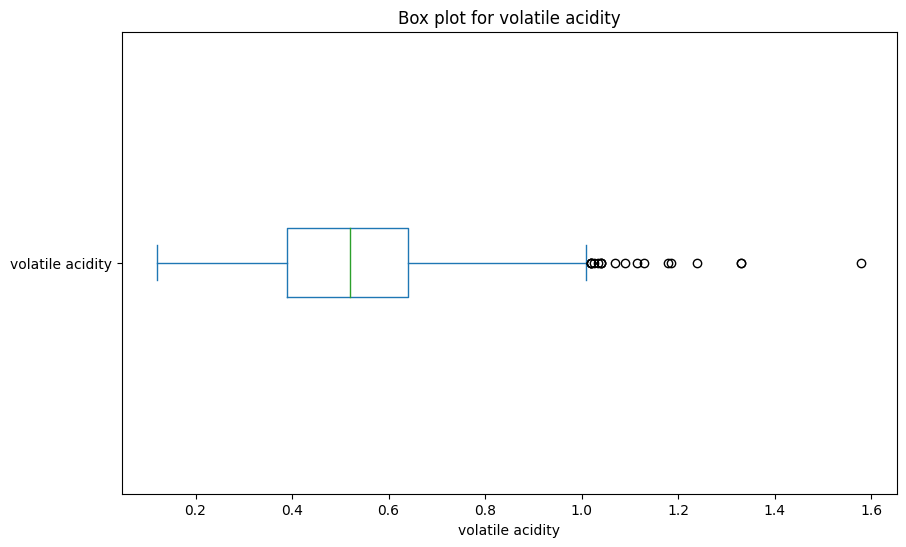

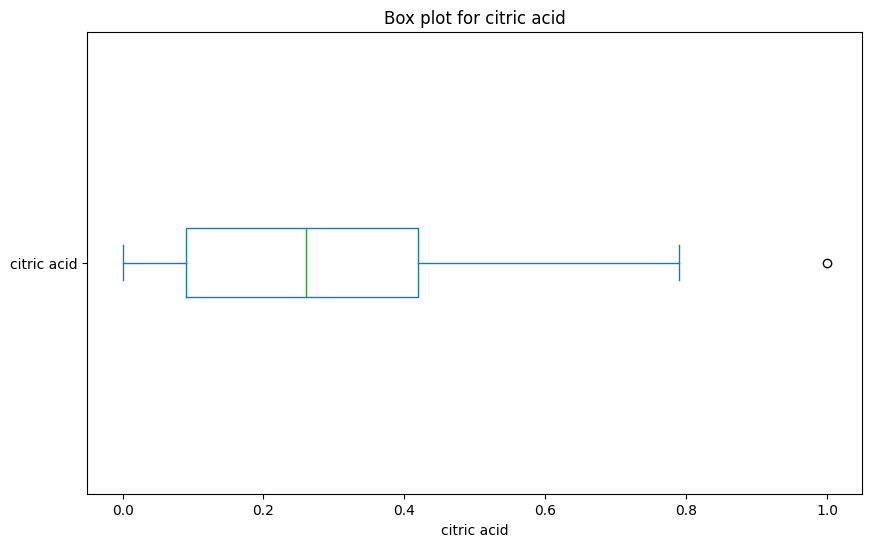

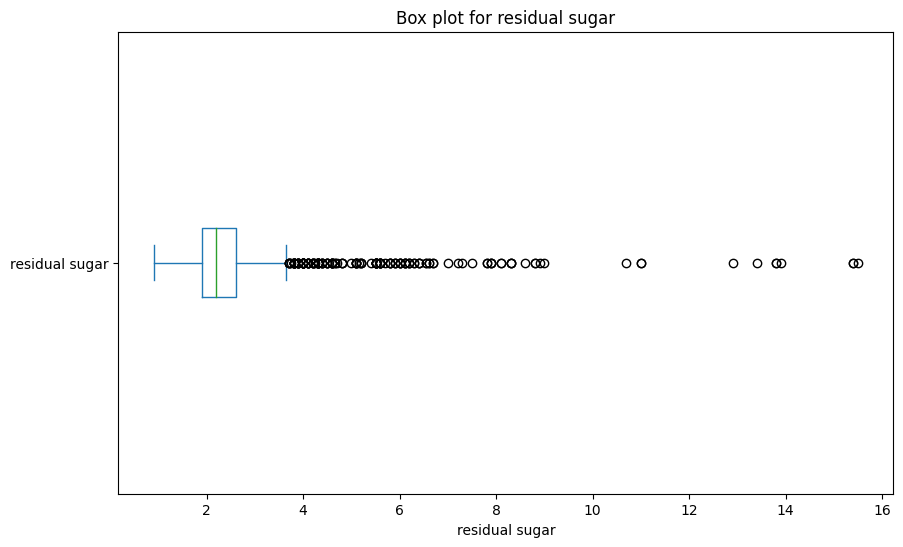

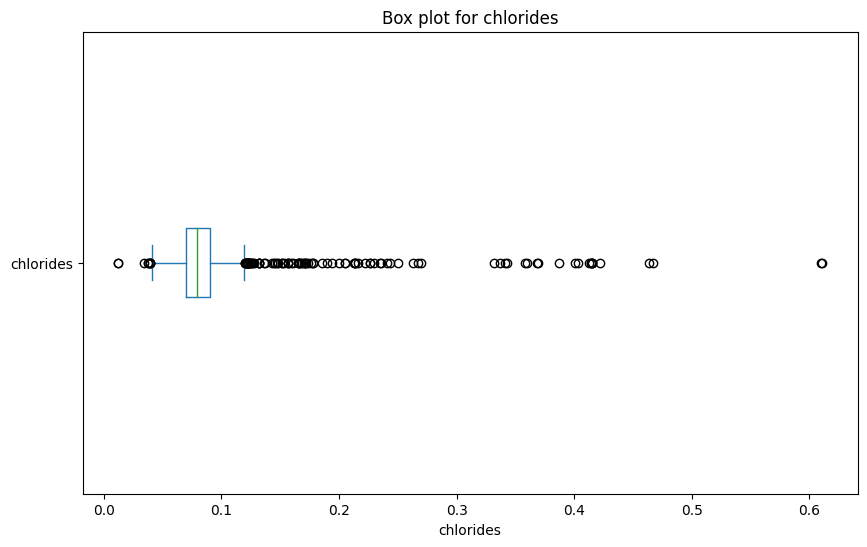

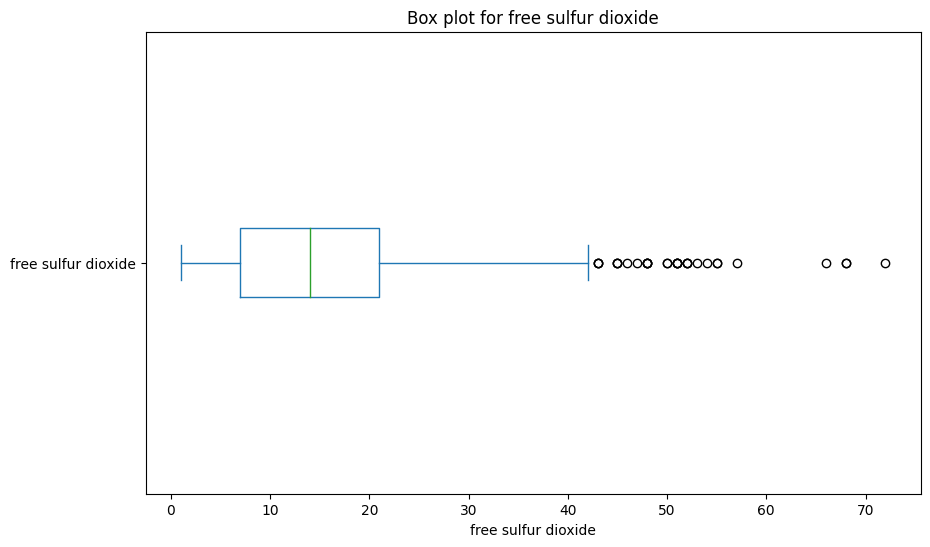

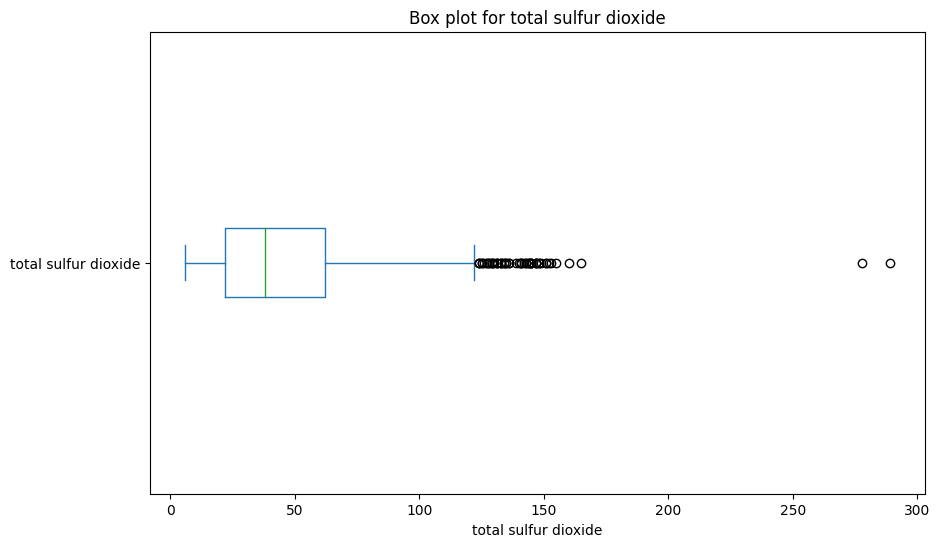

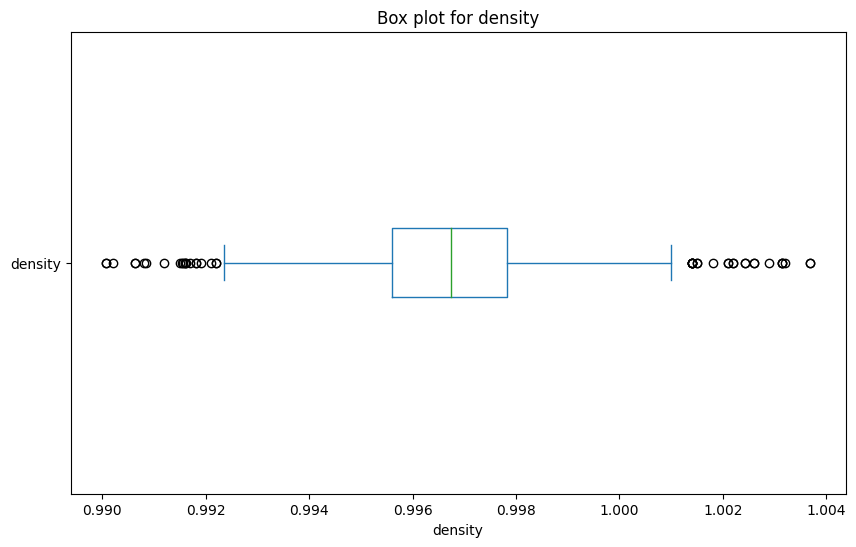

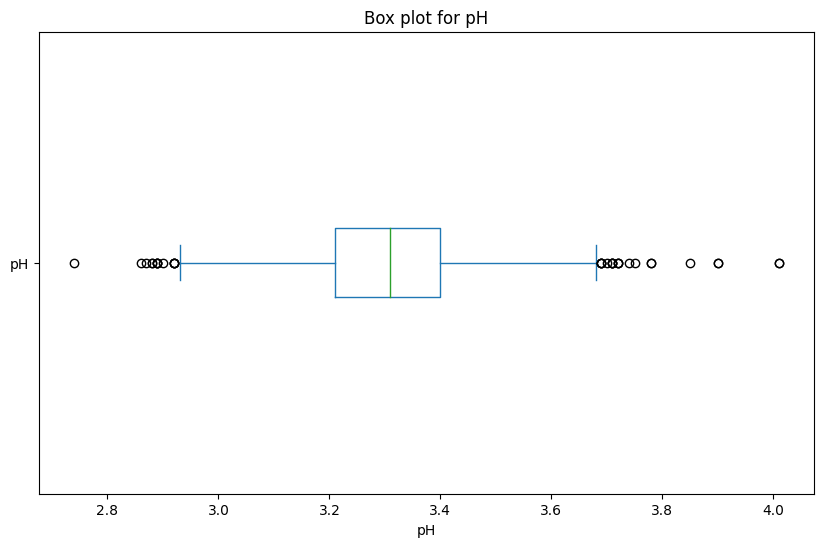

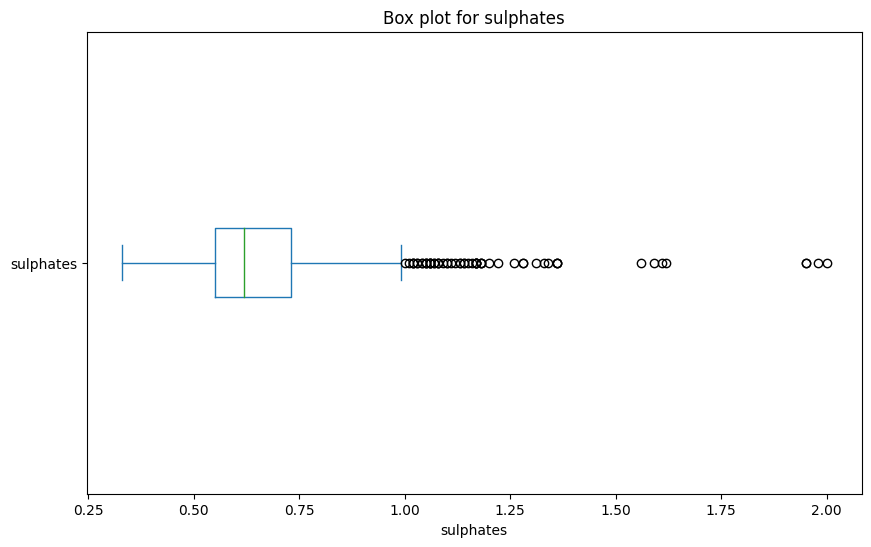

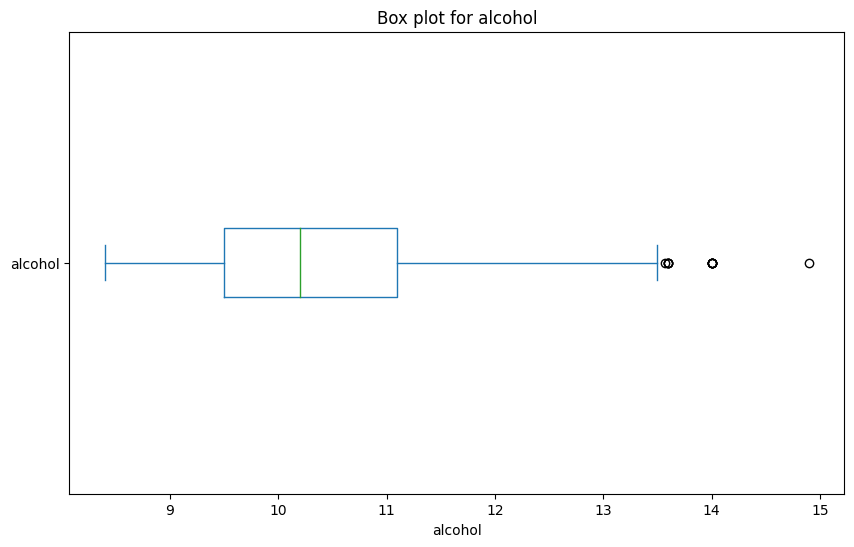

In [12]:
def show_box_plot(df):
    for col in df.columns.values:
        fig=plt.figure(figsize=(10,6))
        df[col].plot.box(vert=False)
        plt.title(f'Box plot for {col}')
        plt.xlabel(col)
        plt.show()
show_box_plot(red_wine_eda.drop(columns='target'))

### Bivariate analysis

#### Between features

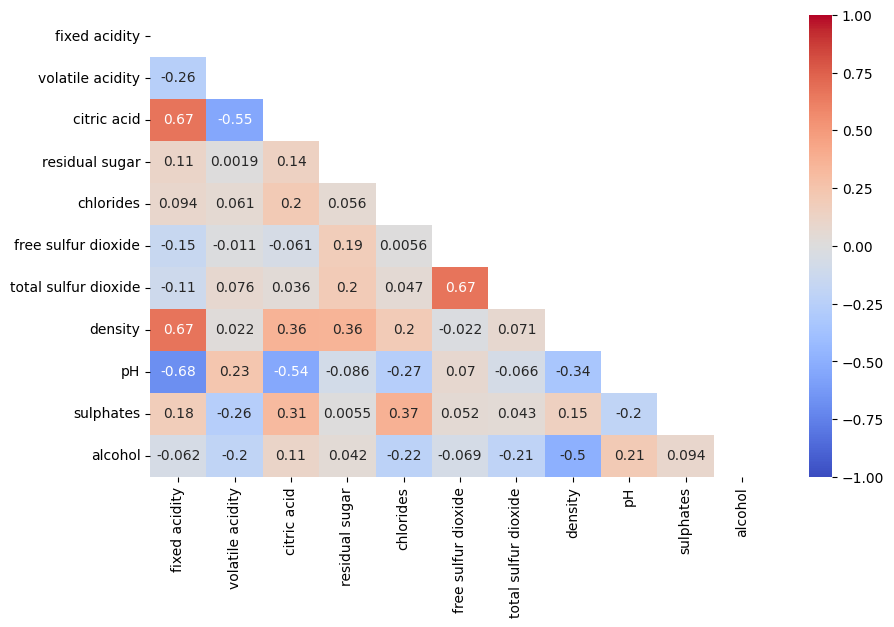

In [13]:
plt.figure(figsize=(10,6))
sns.heatmap(
    red_wine_eda.corr(numeric_only=True),
    vmax=1,
    vmin=-1,
    annot=True,
    cmap='coolwarm',
    mask=np.triu(red_wine_eda.corr(numeric_only=True))
);

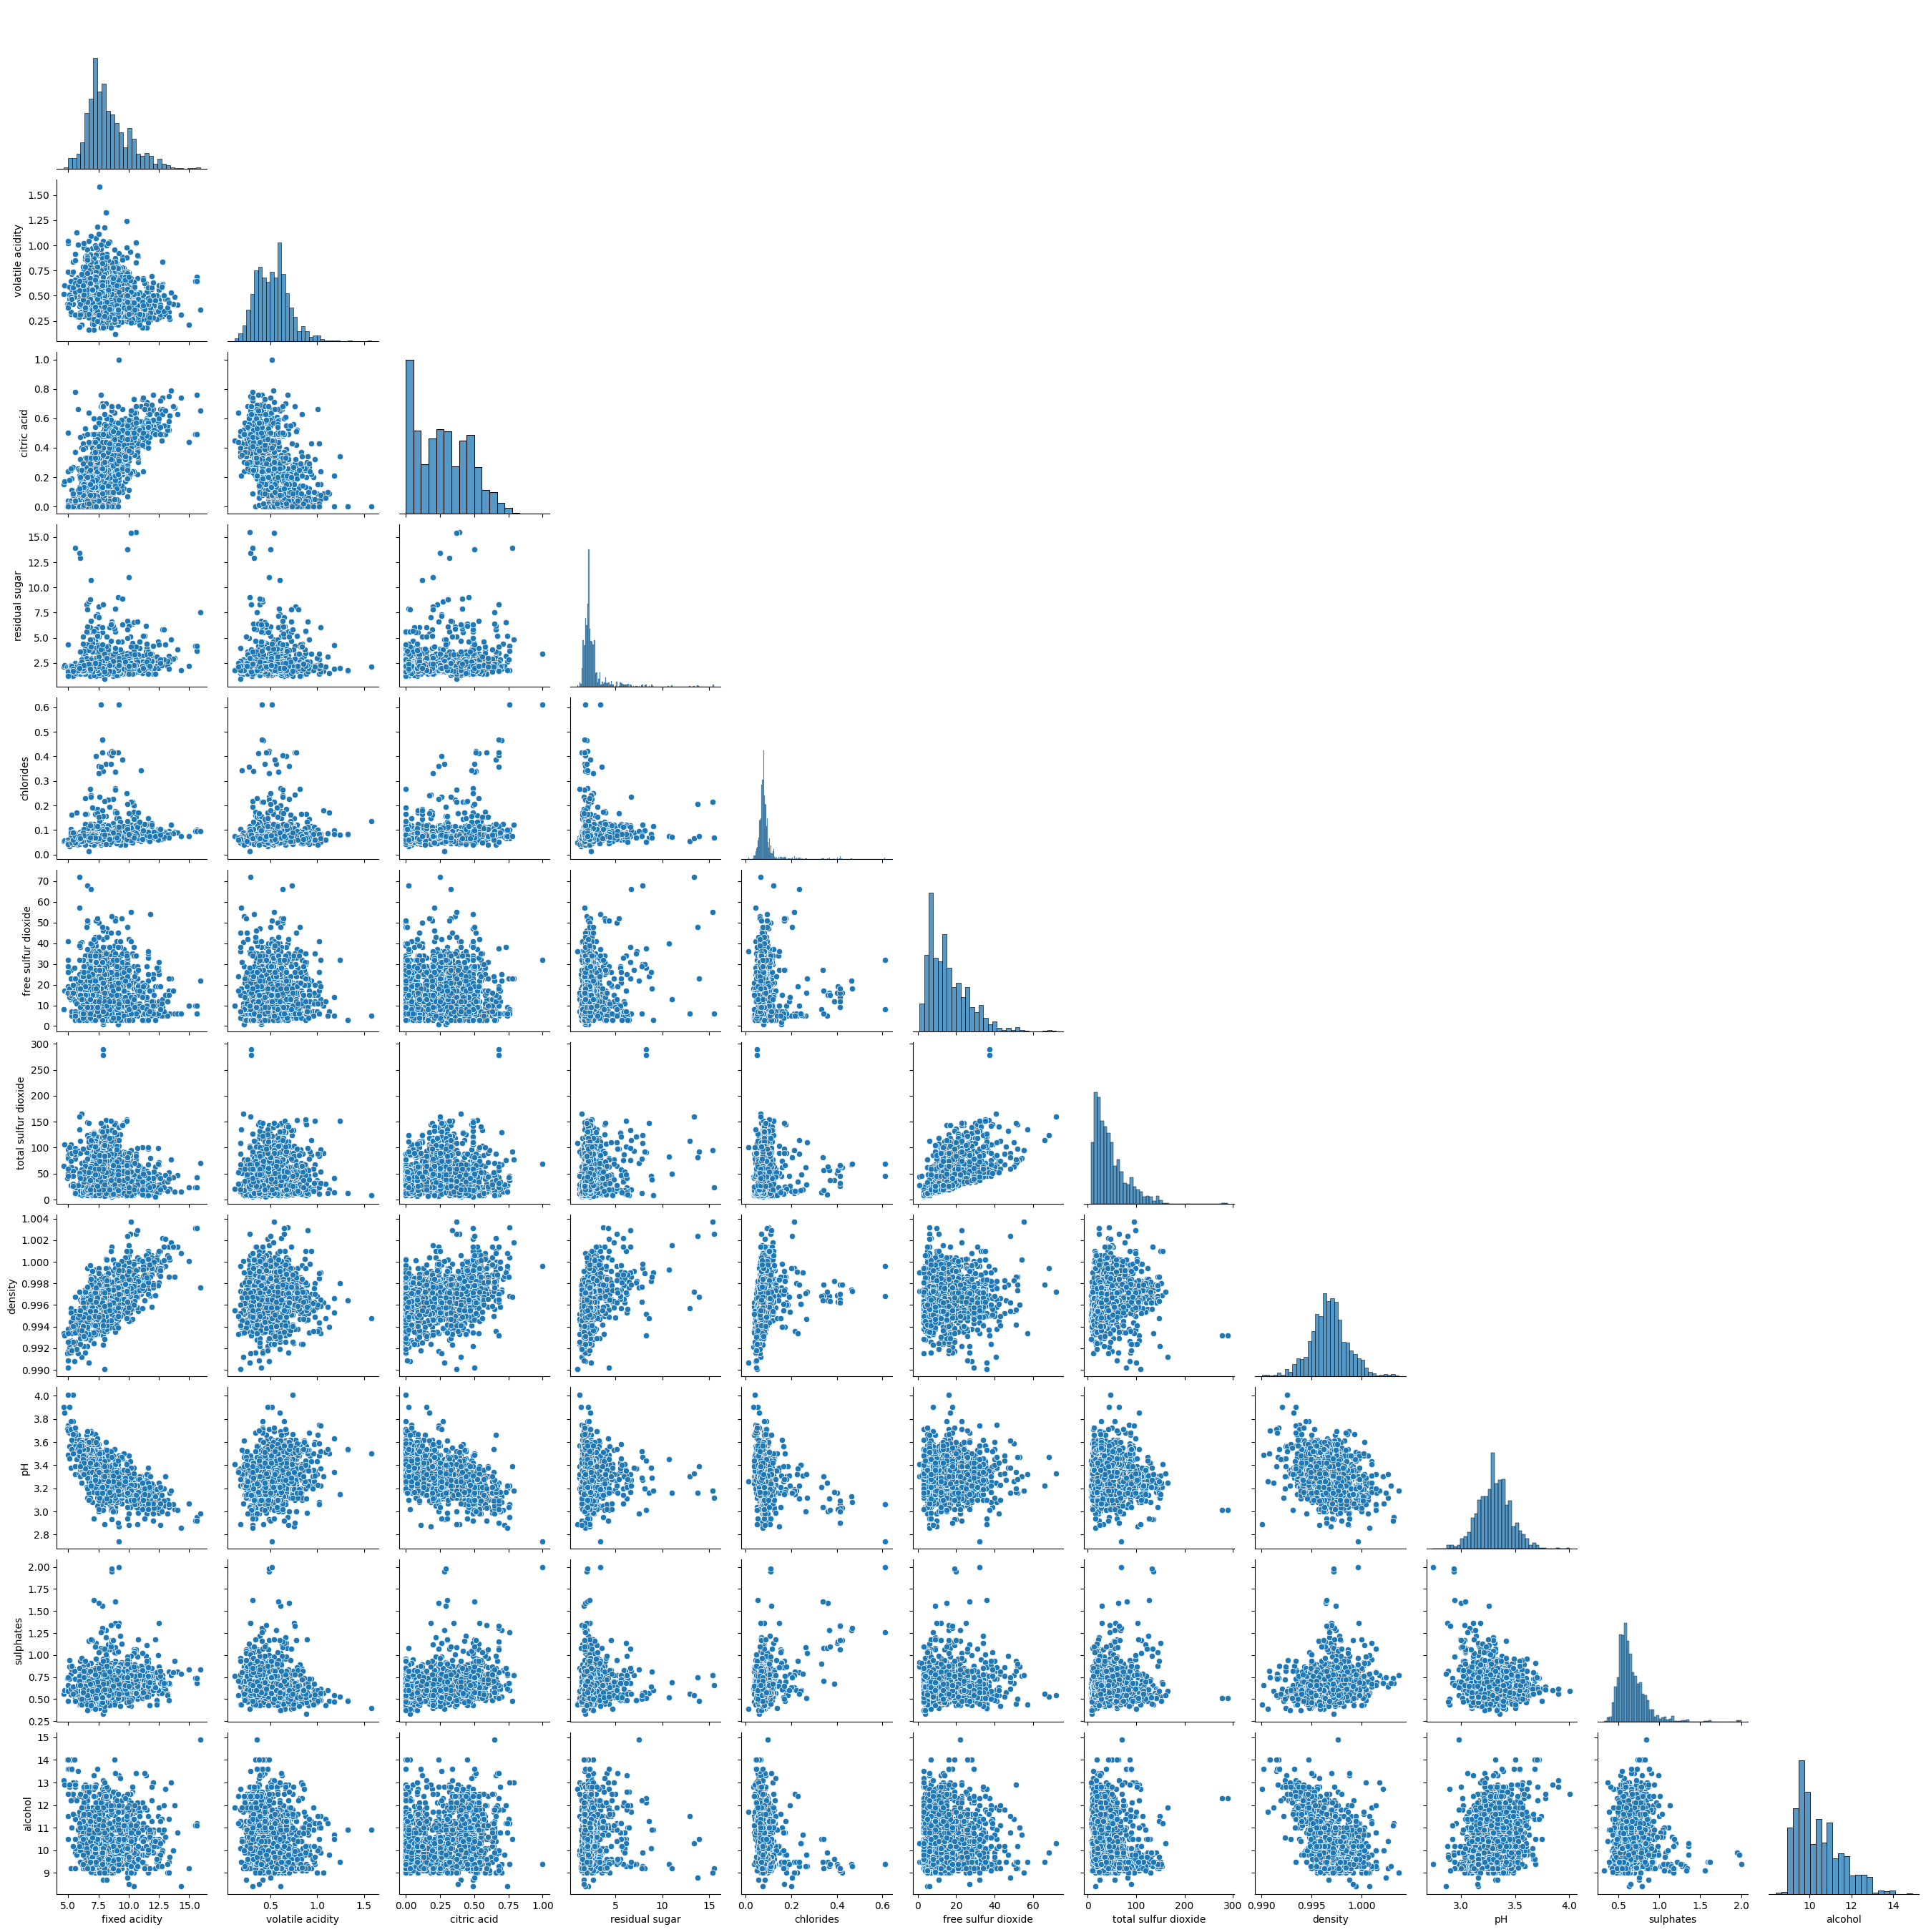

In [14]:
sns.pairplot(
    red_wine_eda,
    corner=True
);

### VIF analysis

### Between features and target

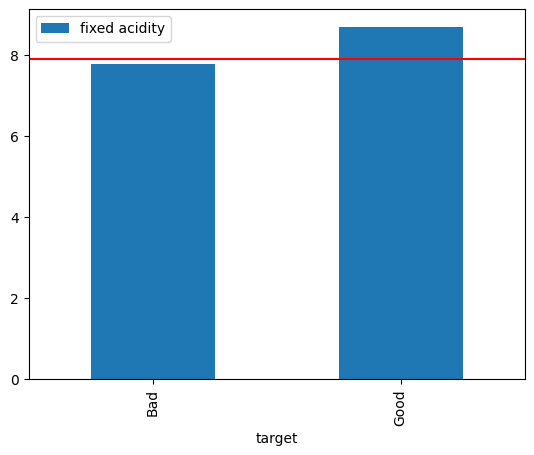

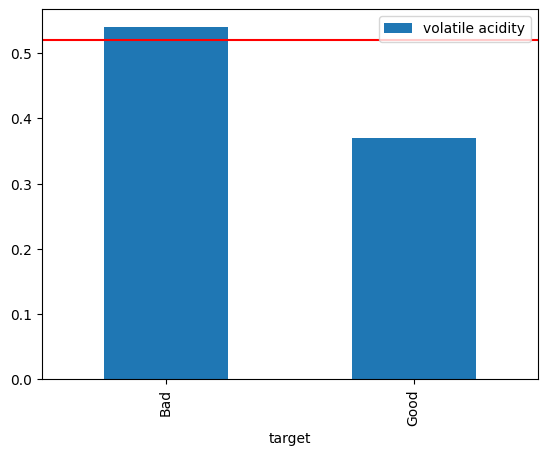

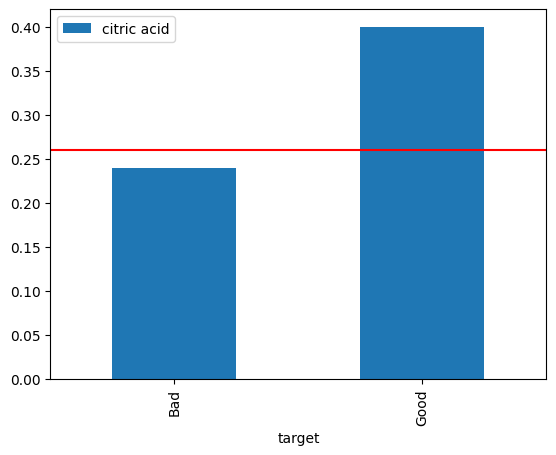

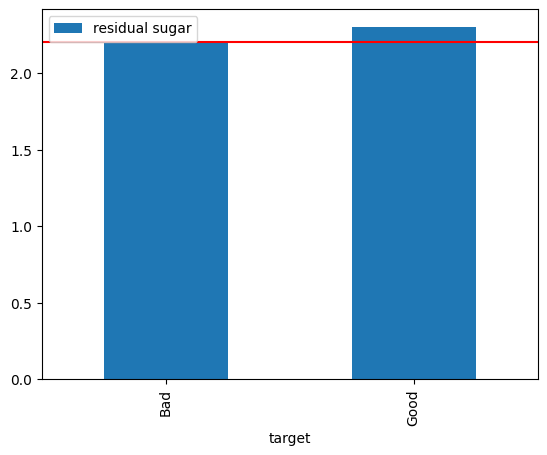

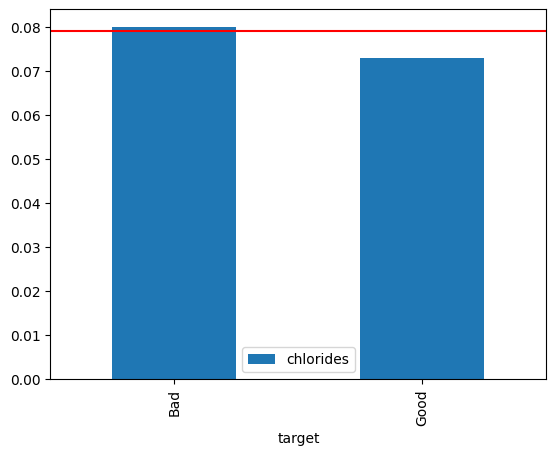

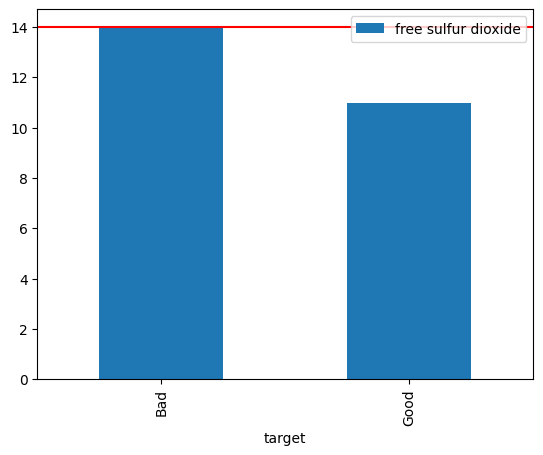

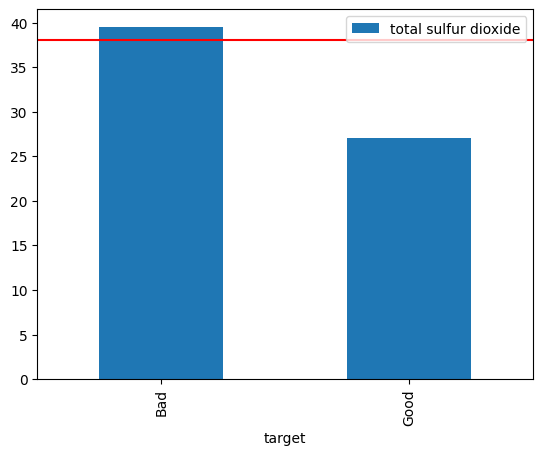

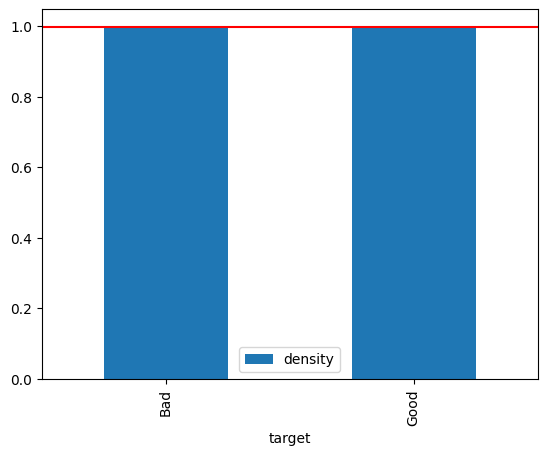

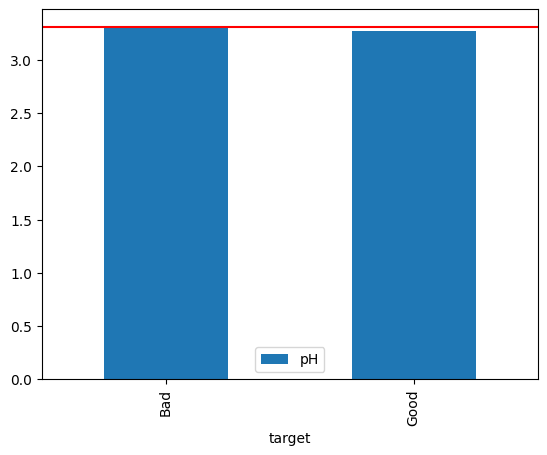

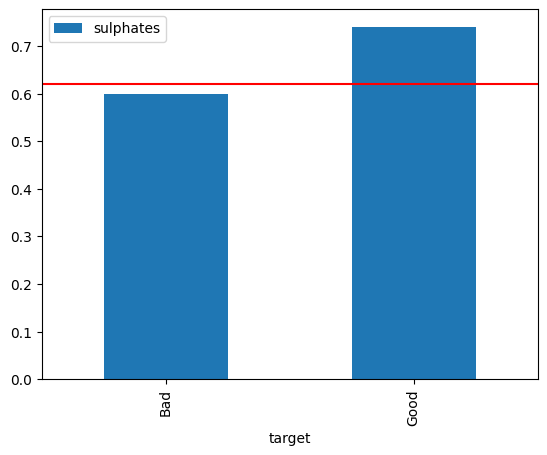

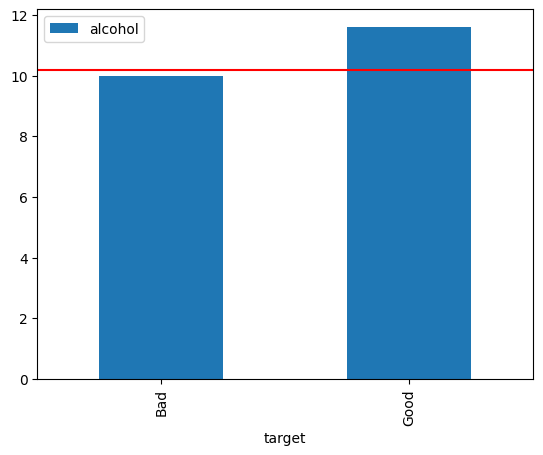

In [15]:
for col in red_wine_eda.drop(columns=['target']).columns.values:
    red_wine_eda.groupby('target').agg({col:'median'}).plot.bar()
    plt.axhline(y=red_wine_eda[col].agg('median'), color='r', linestyle='-')
    plt.show();

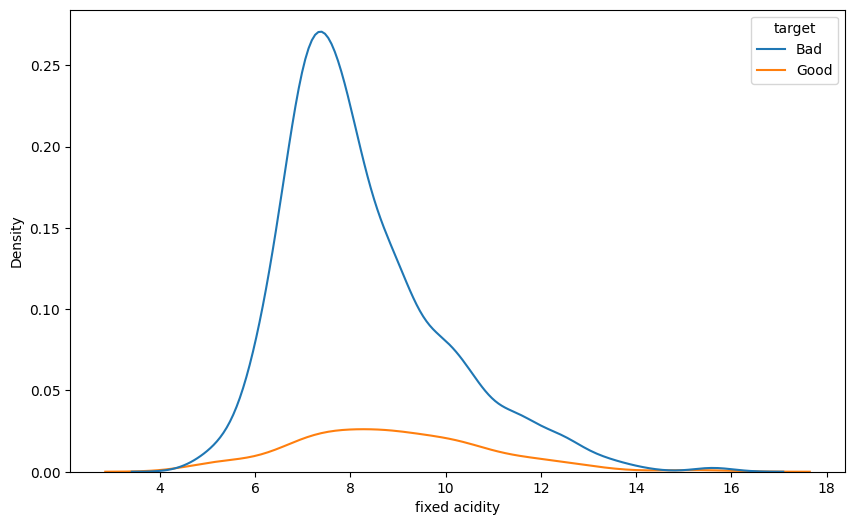

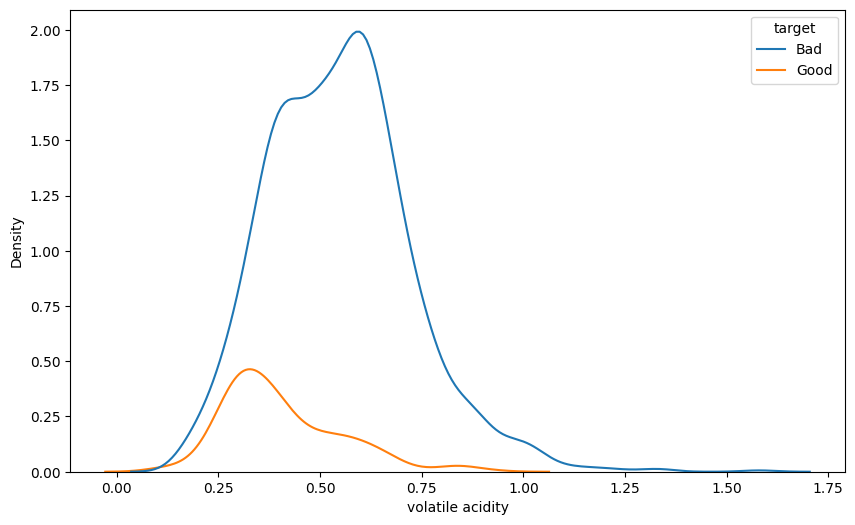

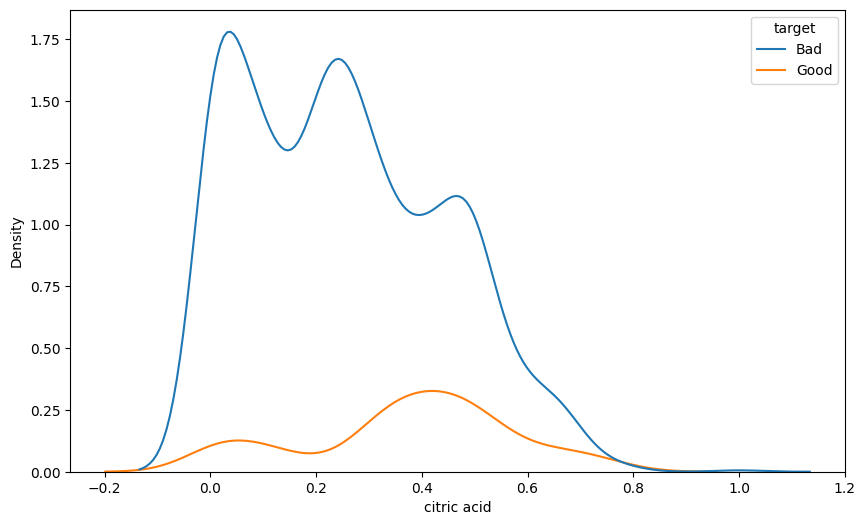

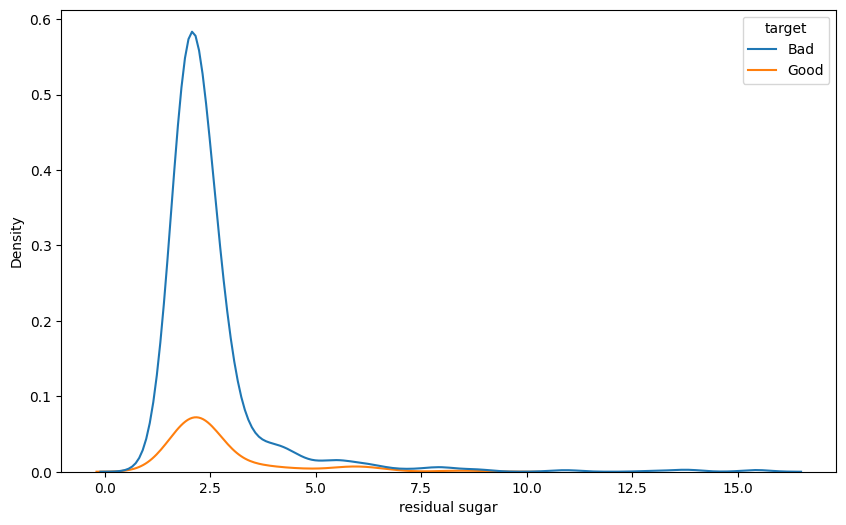

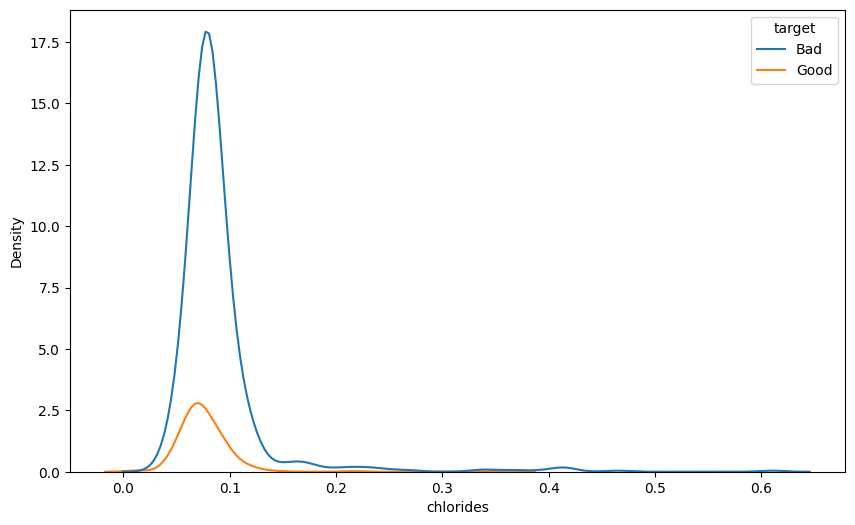

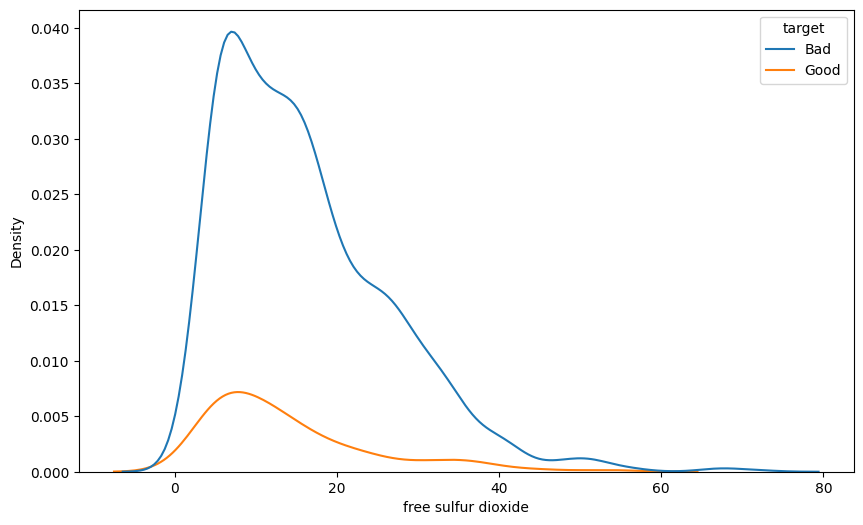

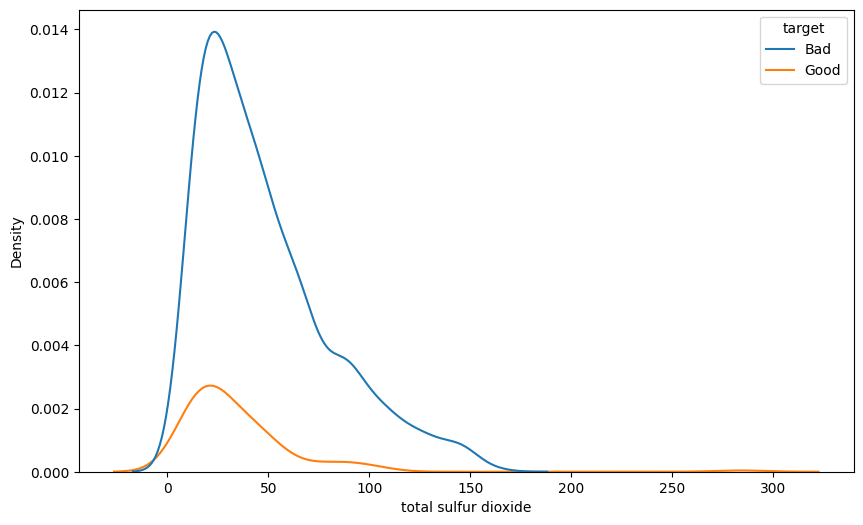

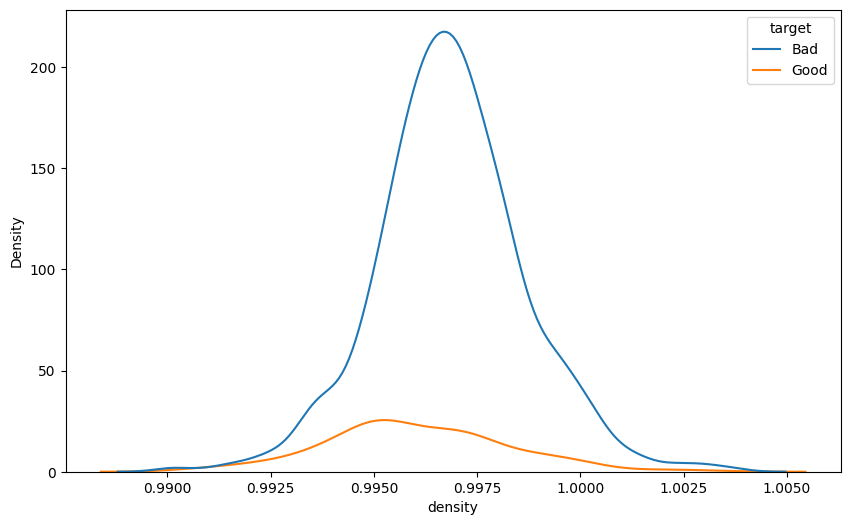

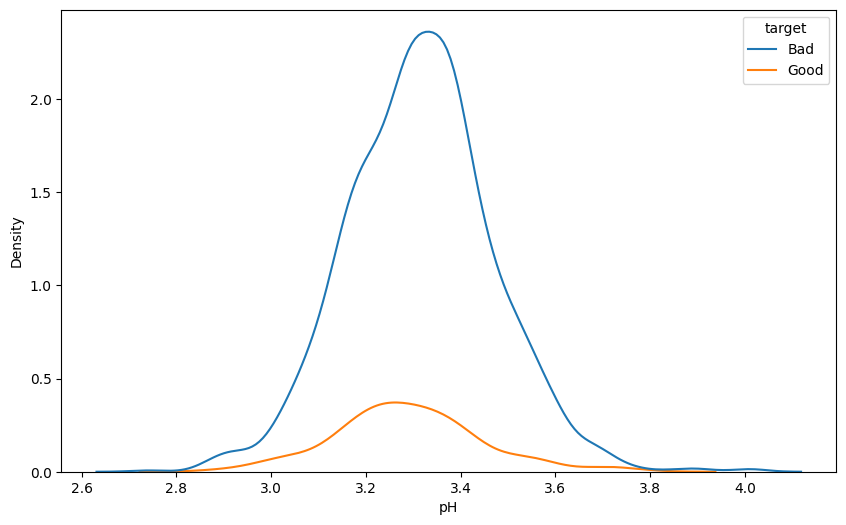

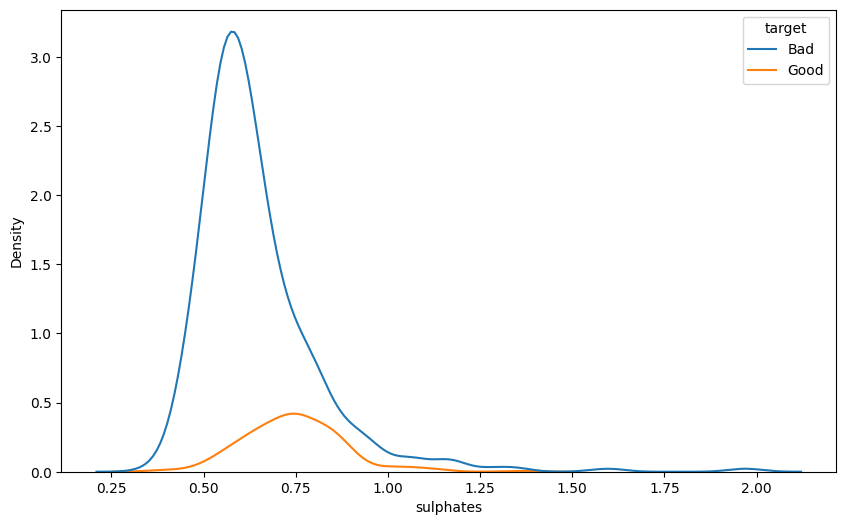

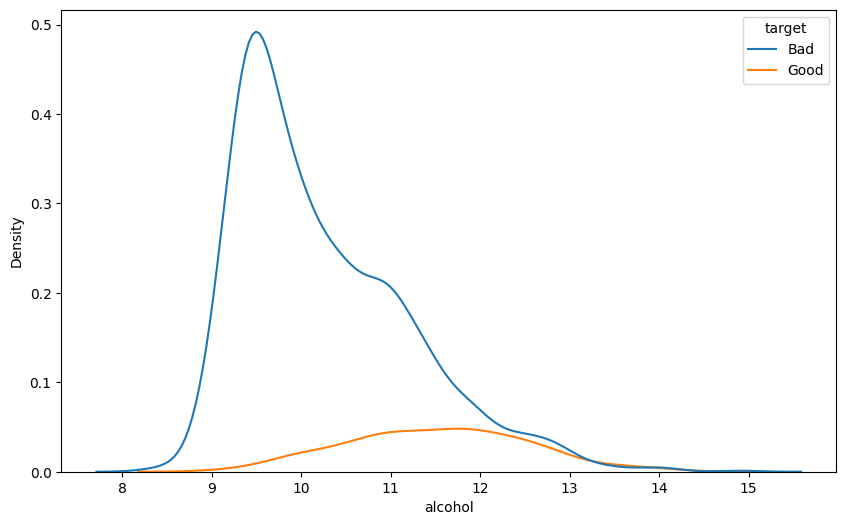

In [16]:
for col in red_wine_eda.drop(columns=['target'],axis=1).columns.values:
    plt.figure(figsize=(10,6))
    sns.kdeplot(
        data=red_wine_eda,
        x=col,
        hue='target'
    );

## Model building

In [17]:
X=red_wine.drop('target',axis=1)
y=red_wine.target
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [18]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=True,stratify=y,random_state=42)

In [19]:
scalar=MinMaxScaler()
scalar.fit(X_train)

MinMaxScaler()

In [20]:
X_train_scaled,X_test_scaled=scalar.transform(X_train),scalar.transform(X_test)

In [21]:
auc={}
for rs in range(0,1000):
    model=RandomForestClassifier(random_state=rs,class_weight='balanced')
    model.fit(X_train_scaled,y_train)
    auc[rs]=roc_auc_score(y_true=y_test,y_score=model.predict_proba(X_test)[:,-1])
best_random_state=max(auc, key=auc.get)
print(best_random_state)
print(f'AUC for random state {best_random_state} = {auc[best_random_state]}')

724
AUC for random state 724 = 0.8228528251196373


### Finding the best ML algorithm

In [22]:
def score_model(model,X,y,n_fold=10):
    compute_class_weight(class_weight='balanced',classes=np.unique(y),y=y)
    k_folds=StratifiedKFold(n_splits=n_fold,shuffle=True)
    return cross_val_score(model,X,y,cv=k_folds,scoring='roc_auc').mean()

In [23]:
# Logistic Regression
lr=LogisticRegression(random_state=best_random_state,class_weight='balanced')
cross_val_auc=score_model(
    model=lr,
    X=X_train_scaled,
    y=y_train
)

lr.fit(X_train_scaled,y_train)
y_pred_proba=lr.predict_proba(X_test_scaled)[:,-1]
test_auc=roc_auc_score(y_true=y_test,y_score=y_pred_proba)
auc_diff=abs(test_auc-cross_val_auc)
print(f'Cross val AUC = {cross_val_auc}')
print(f'Test AUC = {test_auc}')
print(f'Difference in AUC = {auc_diff}')

Cross val AUC = 0.8657084357084356
Test AUC = 0.890605322810847
Difference in AUC = 0.024896887102411447


In [24]:
# Random Forest
rf=RandomForestClassifier(random_state=best_random_state,class_weight='balanced')
cross_val_auc=score_model(
    model=rf,
    X=X_train_scaled,
    y=y_train
)

rf.fit(X_train_scaled,y_train)
y_pred_proba=rf.predict_proba(X_test_scaled)[:,-1]
test_auc=roc_auc_score(y_true=y_test,y_score=y_pred_proba)
auc_diff=abs(test_auc-cross_val_auc)
print(f'Cross val AUC = {cross_val_auc}')
print(f'Test AUC = {test_auc}')
print(f'Difference in AUC = {auc_diff}')

Cross val AUC = 0.9109850090732443
Test AUC = 0.9432457392326421
Difference in AUC = 0.03226073015939779


In [25]:
# Decission Tree
dt=DecisionTreeClassifier(random_state=best_random_state,class_weight='balanced')
cross_val_auc=score_model(
    model=dt,
    X=X_train_scaled,
    y=y_train
)

dt.fit(X_train_scaled,y_train)
y_pred_proba=dt.predict_proba(X_test_scaled)[:,-1]
test_auc=roc_auc_score(y_true=y_test,y_score=y_pred_proba)
auc_diff=abs(test_auc-cross_val_auc)
print(f'Cross val AUC = {cross_val_auc}')
print(f'Test AUC = {test_auc}')
print(f'Difference in AUC = {auc_diff}')

Cross val AUC = 0.7248942525413113
Test AUC = 0.7886827302493492
Difference in AUC = 0.06378847770803786


In [26]:
# Extra Tree
et=ExtraTreeClassifier(random_state=best_random_state,class_weight='balanced')
cross_val_auc=score_model(
    model=et,
    X=X_train_scaled,
    y=y_train
)

et.fit(X_train_scaled,y_train)
y_pred_proba=et.predict_proba(X_test_scaled)[:,-1]
test_auc=roc_auc_score(y_true=y_test,y_score=y_pred_proba)
auc_diff=abs(test_auc-cross_val_auc)
print(f'Cross val AUC = {cross_val_auc}')
print(f'Test AUC = {test_auc}')
print(f'Difference in AUC = {auc_diff}')

Cross val AUC = 0.6951878884231826
Test AUC = 0.7716396608177315
Difference in AUC = 0.07645177239454892


In [27]:
# SVM
svm=SVC(random_state=best_random_state,class_weight='balanced',probability=True)
cross_val_auc=score_model(
    model=svm,
    X=X_train_scaled,
    y=y_train
)

svm.fit(X_train_scaled,y_train)
y_pred_proba=svm.predict_proba(X_test_scaled)[:,-1]
test_auc=roc_auc_score(y_true=y_test,y_score=y_pred_proba)
auc_diff=abs(test_auc-cross_val_auc)
print(f'Cross val AUC = {cross_val_auc}')
print(f'Test AUC = {test_auc}')
print(f'Difference in AUC = {auc_diff}')

Cross val AUC = 0.8794169838287484
Test AUC = 0.8912349928637394
Difference in AUC = 0.011818009034990973


In [28]:
# Gradient Boosting
class_weight=compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)
sample_weights=np.where(y_train==0,class_weight[0],class_weight[-1])
gb=GradientBoostingClassifier(random_state=best_random_state)
cross_val_auc=score_model(
    model=gb,
    X=X_train_scaled,
    y=y_train
)

gb.fit(X_train_scaled,y_train,sample_weight=sample_weights)
y_pred_proba=gb.predict_proba(X_test_scaled)[:,-1]
test_auc=roc_auc_score(y_true=y_test,y_score=y_pred_proba)
auc_diff=abs(test_auc-cross_val_auc)
print(f'Cross val AUC = {cross_val_auc}')
print(f'Test AUC = {test_auc}')
print(f'Difference in AUC = {auc_diff}')

Cross val AUC = 0.8908630020394727
Test AUC = 0.8840567542607675
Difference in AUC = 0.006806247778705199


## Hyperparameter tuning

In [29]:
estimator=GradientBoostingClassifier(random_state=best_random_state)
class_weight=compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)
sample_weights=np.where(y_train==0,class_weight[0],class_weight[-1])
search_spaces={
    'loss':['log_loss','exponential'],
    'learning_rate':np.linspace(0.01,1,1000),
    'n_estimators':np.array(range(100,1010,10)),
    'subsample':np.linspace(0.1,1,1000),
    'criterion':['friedman_mse', 'squared_error']
}
cv=StratifiedKFold(n_splits=10,shuffle=True)
scoring='roc_auc'
n_jobs=-1
n_iter=100
optimizer_kwargs={
    'base_estimator':'GBRT'
}

model=BayesSearchCV(
    estimator=estimator,
    search_spaces=search_spaces,
    cv=cv,
    scoring=scoring,
    optimizer_kwargs=optimizer_kwargs,
    n_iter=n_iter,
    n_jobs=n_jobs,
    random_state=best_random_state,
    refit=True
)

model.fit(X_train_scaled,y_train,sample_weight=sample_weights)

cross_val_auc=score_model(
    model=model,
    X=X_train_scaled,
    y=y_train
)

y_pred_proba=model.predict_proba(X_test_scaled)[:,-1]
test_auc=roc_auc_score(y_true=y_test,y_score=y_pred_proba)
auc_diff=abs(test_auc-cross_val_auc)
print(f'Cross val AUC = {cross_val_auc}')
print(f'Test AUC = {test_auc}')
print(f'Difference in AUC = {auc_diff}')

Cross val AUC = 0.8935484414896179
Test AUC = 0.9059692721014188
Difference in AUC = 0.012420830611800882


## Feature importance

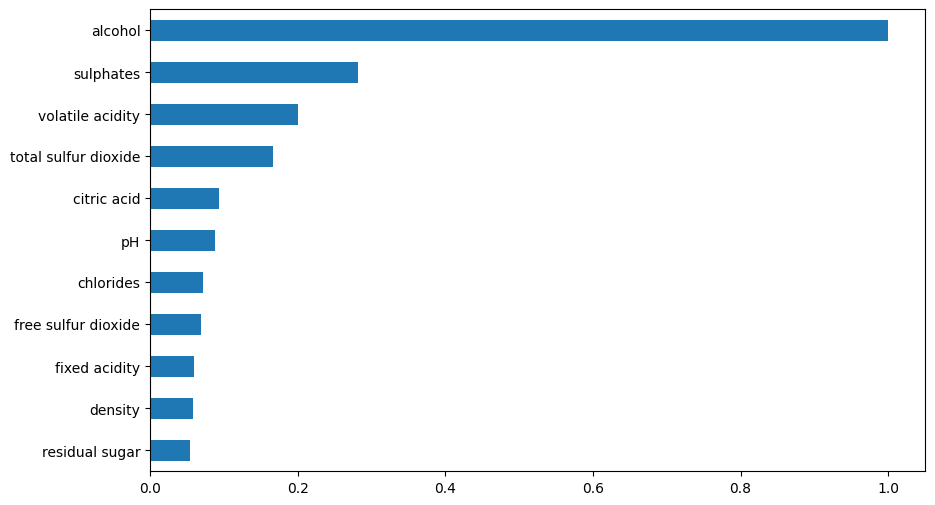

In [30]:
class_weight=compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)
sample_weights=np.where(y_train==0,class_weight[0],class_weight[-1])
model=GradientBoostingClassifier(random_state=best_random_state)
model.fit(X_train_scaled,y_train,sample_weight=sample_weights)
feature_importance=pd.Series(index=X.columns.values,data=model.feature_importances_/model.feature_importances_.max())
plt.figure(figsize=(10,6))
feature_importance.sort_values().plot.barh();

## Partial dependence plot

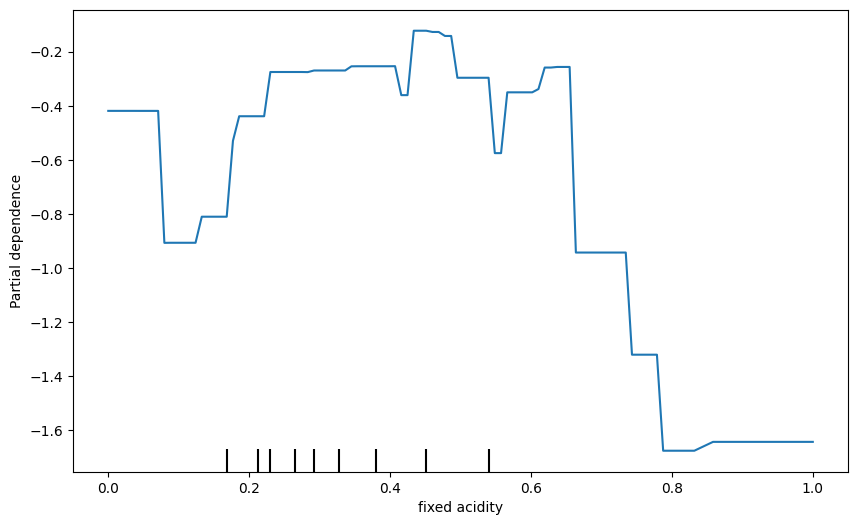

<Figure size 1000x600 with 0 Axes>

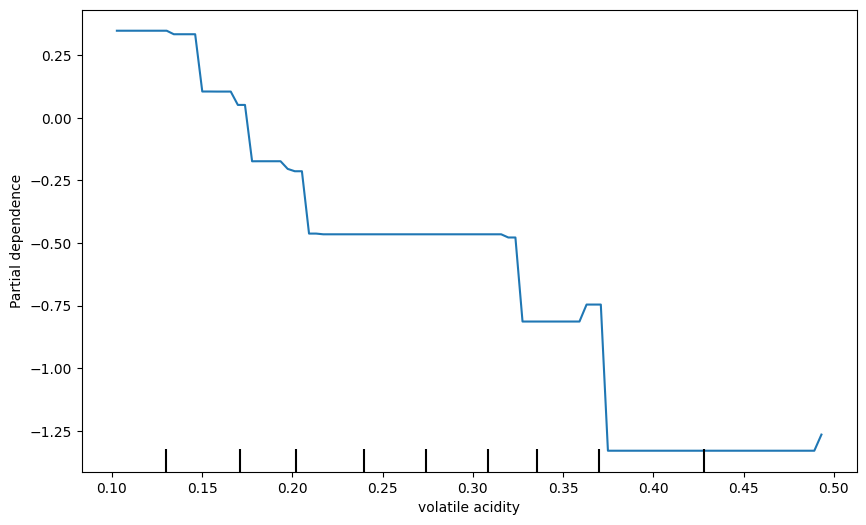

<Figure size 1000x600 with 0 Axes>

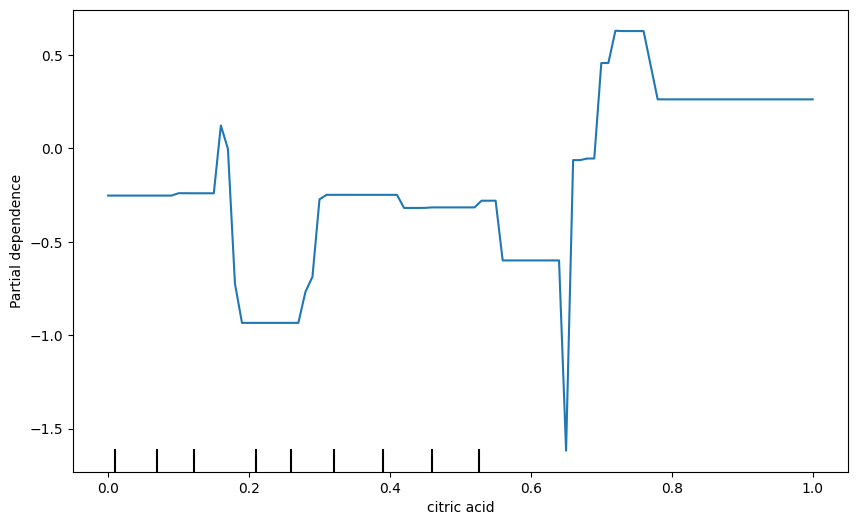

<Figure size 1000x600 with 0 Axes>

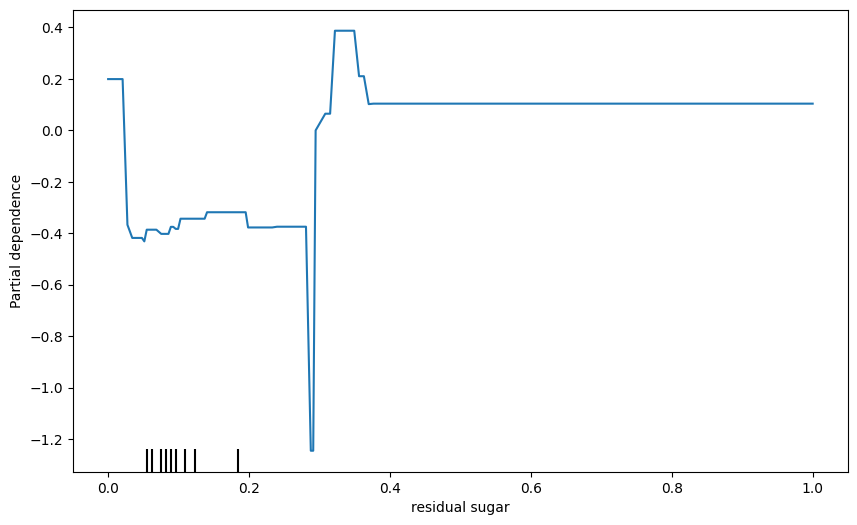

<Figure size 1000x600 with 0 Axes>

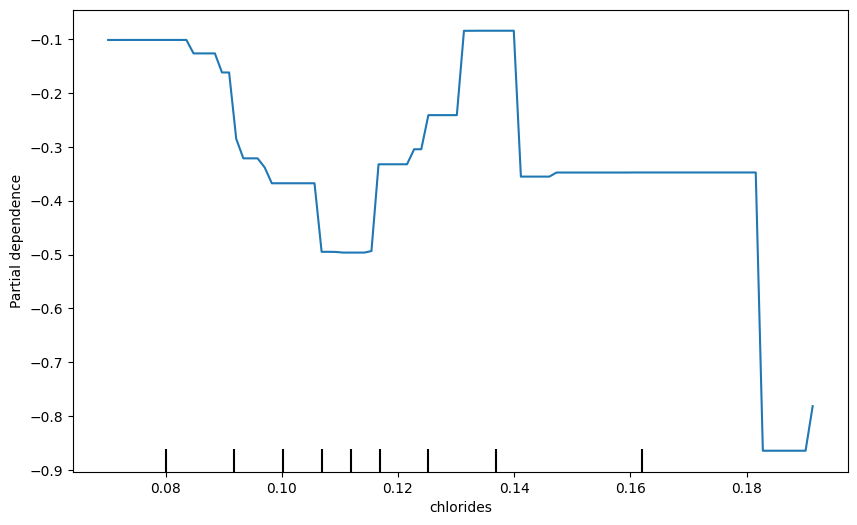

<Figure size 1000x600 with 0 Axes>

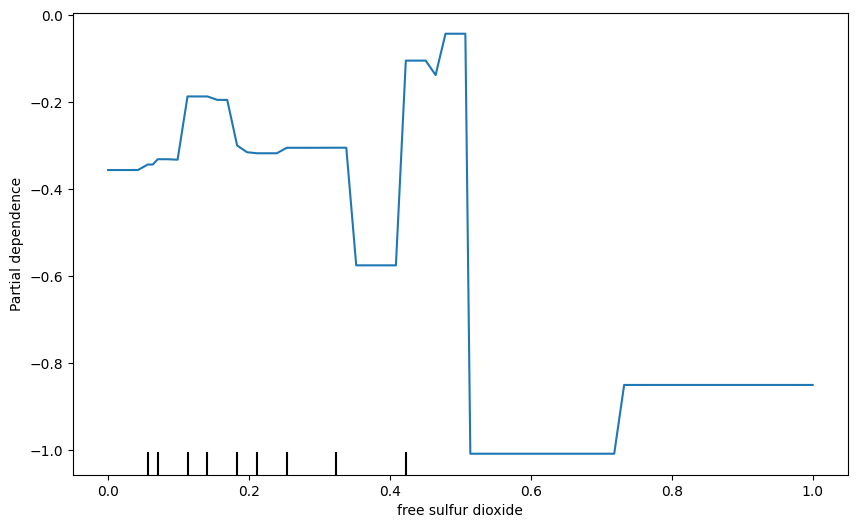

<Figure size 1000x600 with 0 Axes>

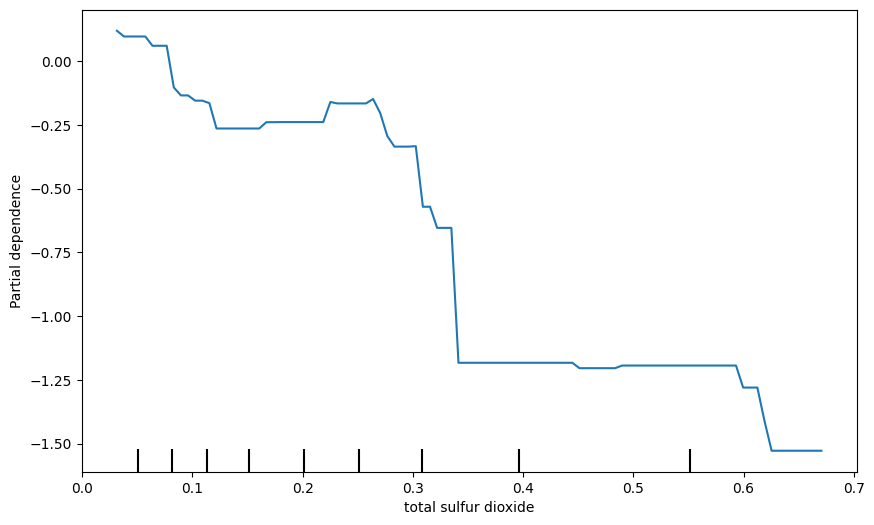

<Figure size 1000x600 with 0 Axes>

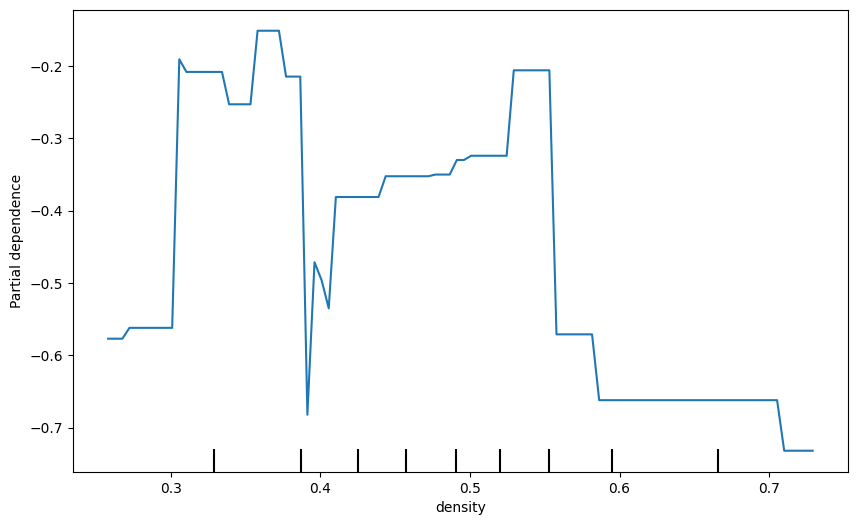

<Figure size 1000x600 with 0 Axes>

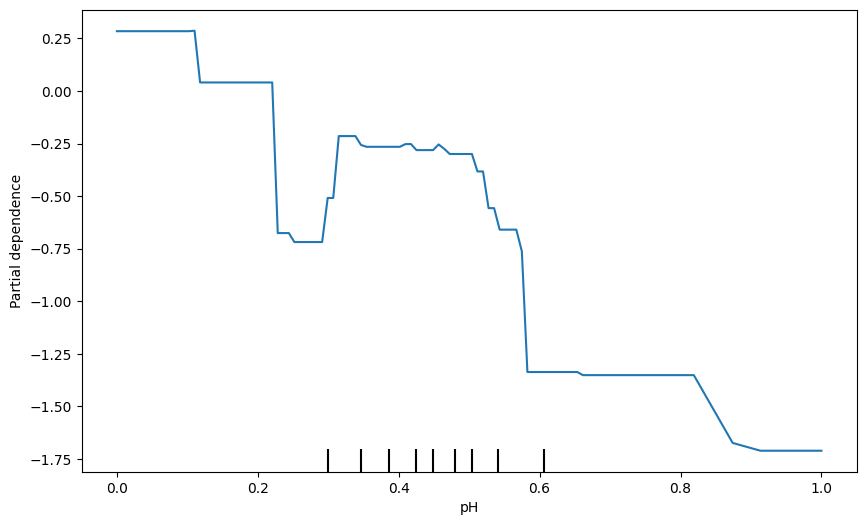

<Figure size 1000x600 with 0 Axes>

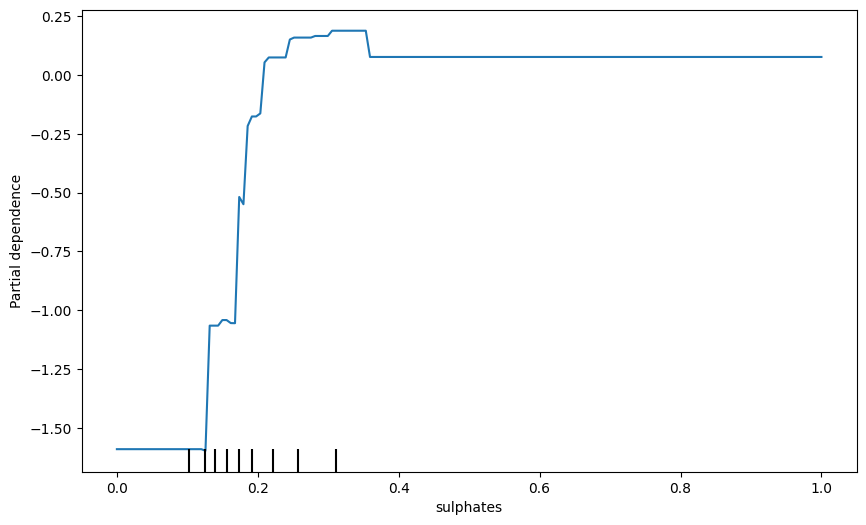

<Figure size 1000x600 with 0 Axes>

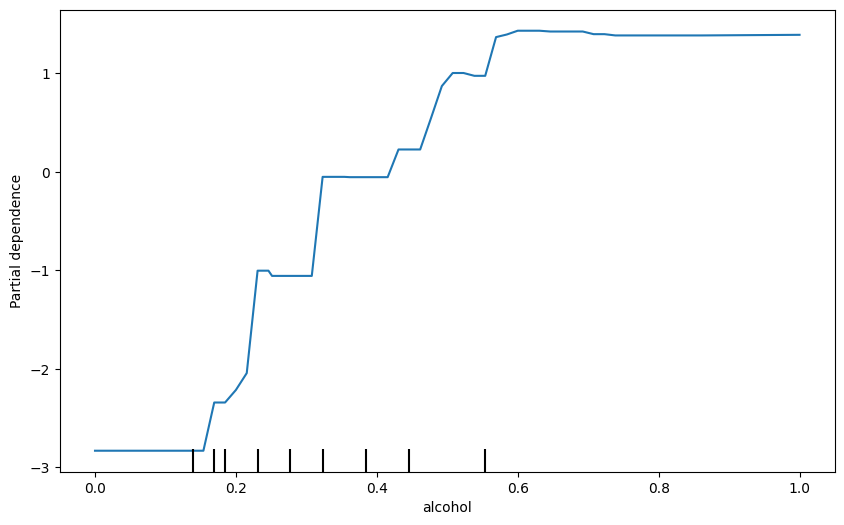

<Figure size 1000x600 with 0 Axes>

In [31]:
pred_df=pd.DataFrame(columns=X.columns.values,
                     data=scalar.transform(X))
for col in pred_df.columns.values:
    fig,ax=plt.subplots(figsize=(10, 6))
    plt.figure(figsize=(10,6))
    tree_disp = PartialDependenceDisplay.from_estimator(model, pred_df, [col],ax=ax);

## Final model by droping the insignificant features

In [32]:
final_features=['volatile acidity','total sulfur dioxide','pH','sulphates','alcohol']
X_final=X[final_features].copy()
X_train_final,X_test_final,y_train_final,y_test_final=train_test_split(X_final,y,test_size=0.2,shuffle=True,random_state=42,stratify=y)
scalar=MinMaxScaler()
scalar.fit(X_train_final)
X_train_final_scaled=scalar.transform(X_train_final)
X_test_final_scaled=scalar.transform(X_test_final)
final_model=GradientBoostingClassifier(random_state=best_random_state)
final_model.fit(X_train_final_scaled,y_train_final,sample_weight=sample_weights)
y_pred_proba=final_model.predict_proba(X_test_final_scaled)[:,-1]
test_auc=roc_auc_score(y_true=y_test,y_score=y_pred_proba)
test_auc

0.870204013097137

## ROC curve and classification report for the final model

In [33]:
def custom_predict(model,X,y):
    y_pred_proba=model.predict_proba(X)[:,-1]
    f1_dict={}
    for threshold in np.linspace(0,1,1001):
        y_pred=np.where(y_pred_proba>=threshold,1,0)
        f1_dict[threshold]=f1_score(y_true=y,y_pred=y_pred,average='weighted')
    the_threshold=max(f1_dict,key=f1_dict.get)
    print(f'Optimum cutoff = {the_threshold}')
    return np.where(y_pred_proba>=the_threshold,1,0)

Optimum cutoff = 0.807
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       277
           1       0.89      0.56      0.69        43

    accuracy                           0.93       320
   macro avg       0.91      0.77      0.82       320
weighted avg       0.93      0.93      0.92       320



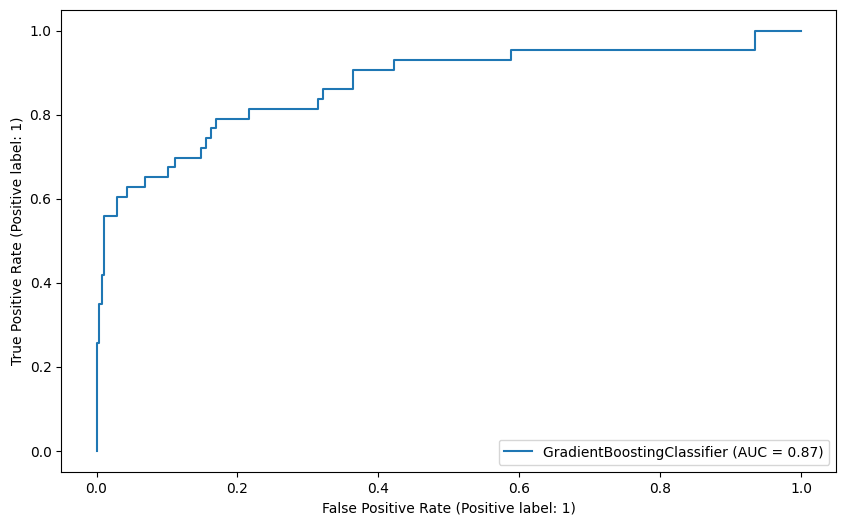

In [34]:
fig,ax=plt.subplots(figsize=(10,6))
RocCurveDisplay.from_estimator(final_model,X_test_final_scaled,y_test,ax=ax)
print(classification_report(y_test,custom_predict(final_model,X_test_final_scaled,y_test)))

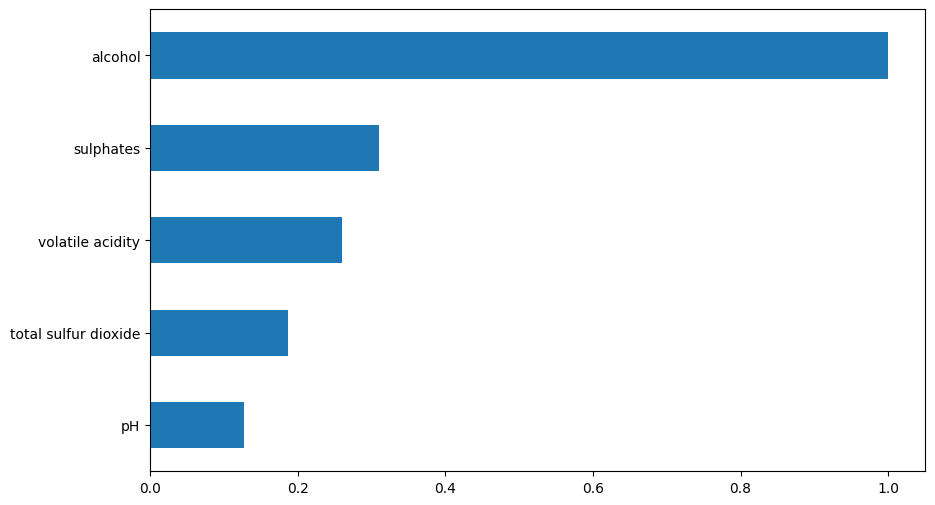

In [35]:
feature_importance=pd.Series(index=X_final.columns.values,data=final_model.feature_importances_/final_model.feature_importances_.max())
plt.figure(figsize=(10,6))
feature_importance.sort_values().plot.barh();

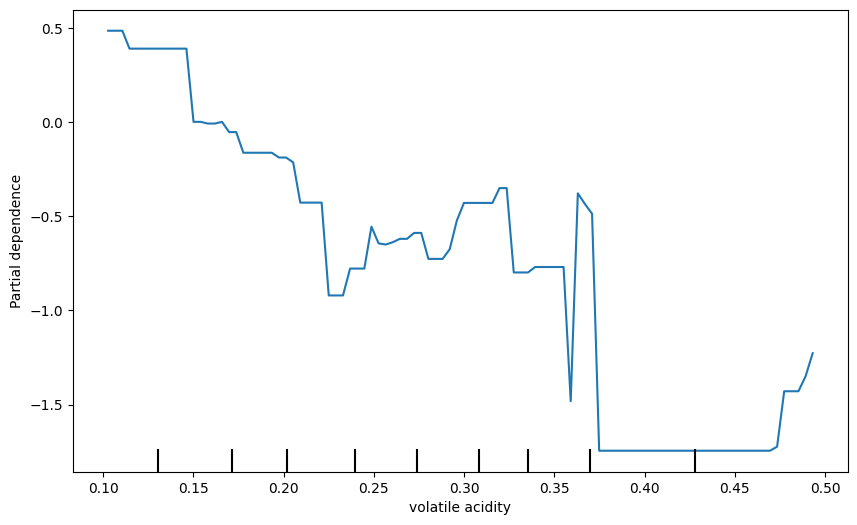

<Figure size 1000x600 with 0 Axes>

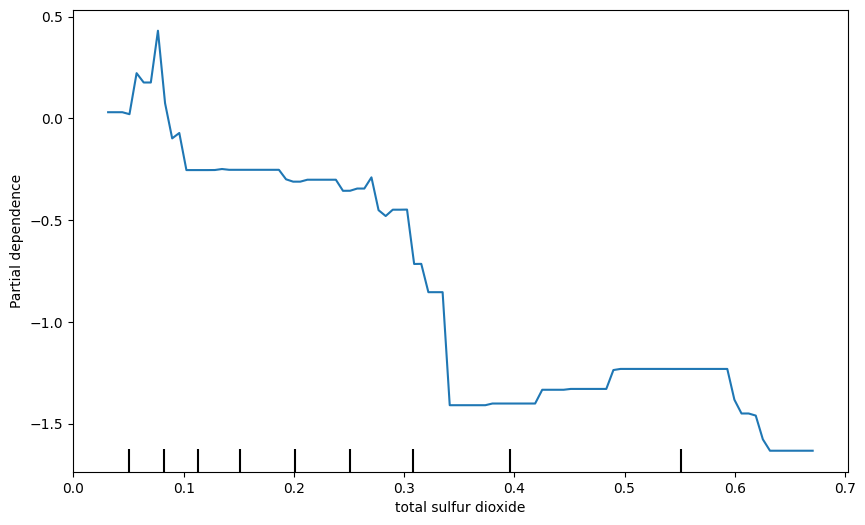

<Figure size 1000x600 with 0 Axes>

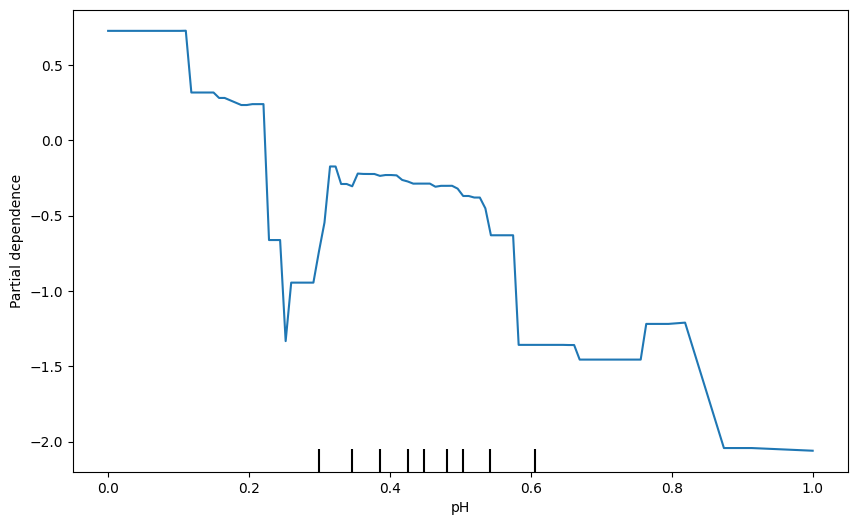

<Figure size 1000x600 with 0 Axes>

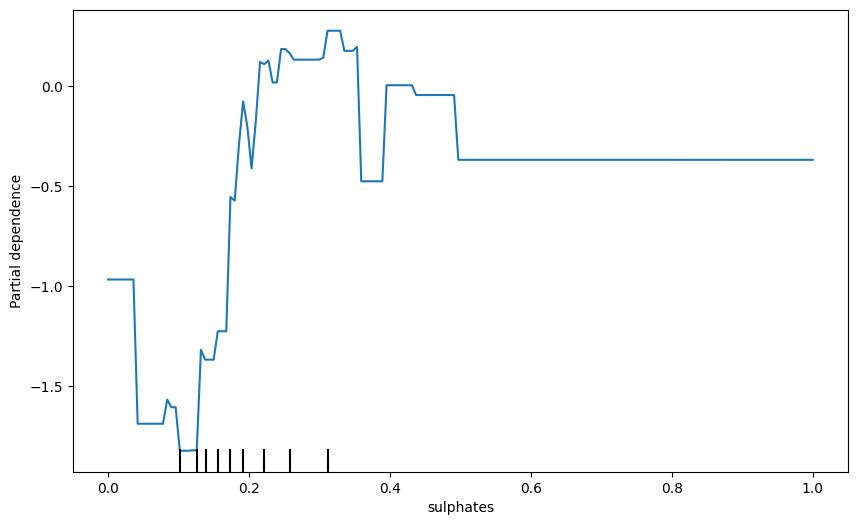

<Figure size 1000x600 with 0 Axes>

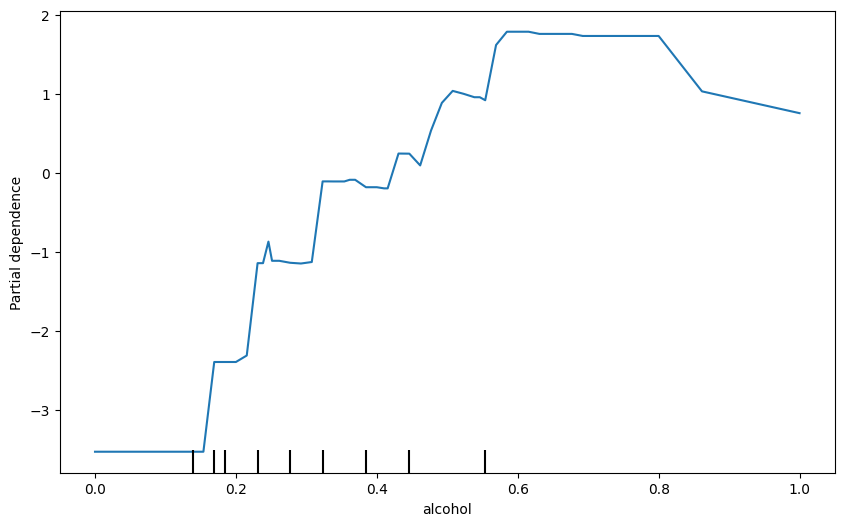

<Figure size 1000x600 with 0 Axes>

In [36]:
pred_df=pd.DataFrame(columns=X_final.columns.values,
                     data=scalar.transform(X_final))
for col in pred_df.columns.values:
    fig,ax=plt.subplots(figsize=(10, 6))
    plt.figure(figsize=(10,6))
    tree_disp = PartialDependenceDisplay.from_estimator(final_model,
                                                        pred_df,
                                                        [col],
                                                        kind='average',
                                                        ax=ax
                                                        );

## Insights

### Based on the above analyses, Only the following physiochemical properties influence the red wine quality
* alcohol
* sulphates
* pH
* total sulfur dioxide
* volatile acidity

The most important factor has turned out to be the alcohol followed by sulphates, volatile acidity, total sulfur dioxide and pH. The analyses gained the following observations.
* Greater amount of alcohol is more likely to produce higher quality wines in general. However, too much alcohol degrades the quality. Hence, moderate to high alcohol might be recommended for an optimal quality of wine. 
* While wine quality gets better with higher concentration of sulphates, it looses its effect on quality beyond moderate concentration. Hence, a medium concentration would be the most optimum.
* Lower volatile acidity tends to produce a better quality of wine.
* Similarly, lower concentration of total sulfur dioxide is likely to produce superior quality.
* Finally, wines with lower pH is more likely to be of better quality than wines with higher pH.